In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sb
import os, glob, warnings
import re
import tarfile
from IPython.display import display, Image
from astropy.stats import sigma_clip
import matplotlib.cm as cm
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

warnings.filterwarnings("ignore")
sb.set(style="ticks", color_codes=True, context="notebook", font_scale=1.4)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

mainpath = '/Users/jorgetil/Astro/HITS'
save_plot = False

### Summary table

|          |  2014 | 2015  | total  |
|----------|-------|-------|--------|
| SDSS Gal | 6,703 | 7,592 | 12,312*|
| Var Gal  |   430 |   317 |    747 |
| x Chill  |     3 |     2 |     5**|
| x Liu    |     5 |     5 |     8**|
| VarGal IMBH| 2***|     3 |      5 |
| Gal 2y   | 1,983 | 1,983 |  1,983 |
| VarGal 2y|    45 |    45 |     45 |
| X-Ray^   |    24 |    11 |   28^^^|
| Radio^^  |    13 |     9 |     20'|

\* Unique items

\** Unique items, both years adds 12 IMBH candidates observed by HiTS

\*** One of the is labeled as QSO

^ XMM, CHANDRAN & SWIFT

^^ VLA FIRST

^^^ 7 sources with x-ray data observed during both years

' 2 sources with radio data observed during both years

1 source with x-ray and radio data in 2014, none for 2015


### 32 fields with galaxies from SDSS on 2014 and 2015
### => 96 sq. deg. effective

In [2]:
def k_corr_SDSS(g, r, z, band='g'):
    # O'Mill et al. 2010 SDSS DR7
    print band
    a_A = {}
    a_B = {}
    b_A = {}
    b_B = {}
    a_A['u'] = 2.956
    a_A['g'] = 3.070
    a_A['r'] = 1.771
    a_A['i'] = 0.538
    a_A['z'] = 0.610
    
    b_A['u'] = -0.100
    b_A['g'] = 0.727
    b_A['r'] = -0.529
    b_A['i'] = -0.075
    b_A['z'] = -0.064
    
    a_B['u'] = -0.299
    a_B['g'] = -0.313
    a_B['r'] = -0.179
    a_B['i'] = -0.027
    a_B['z'] = -0.061
    
    b_B['u'] = -0.095
    b_B['g'] = -0.173
    b_B['r'] = -0.048
    b_B['i'] = -0.120
    b_B['z'] = -0.106
    
    return (a_A[band] * (g - r) + b_A[band]) * z + (a_B[band] * (g - r) + b_B[band])
    

In [3]:
data_14 = pd.read_csv('%s/tables/galaxy/Blind14A_feat_SDSS_galaxy_psfmatch_variable_cand.csv.gz'
                      % (mainpath), compression='gzip')
data_14.set_index('internalID', inplace=True)
data_15 = pd.read_csv('%s/tables/galaxy/Blind15A_feat_SDSS_galaxy_psfmatch_variable_cand.csv.gz'
                      % (mainpath), compression='gzip')
data_15.set_index('internalID', inplace=True)
data = pd.read_csv('%s/tables/galaxy/HiTS_14u15_feat_SDSS_galaxy_psfmatch_variable_cand.csv'
                      % (mainpath))
data.set_index('internalID', inplace=True)

print '2014       : ', data_14.shape
print '2015       : ', data_15.shape
print '2014 U 2015: ', data.shape

2014       :  (302, 90)
2015       :  (229, 90)
2014 U 2015:  (502, 92)


In [4]:
# getting distance and absolute magnitudes using astropy.cosmology library
# with a Flat Lambda CDM universe
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, 
                      Tcmb0=2.725 * u.K, 
                      Om0=0.3089,
                      Ob0=0.0486)
    
for band in 'ugriz':
    lum_dist = cosmo.luminosity_distance(data.zsp)
    data['%sMag_k' % (band)] = data['%smag' % (band)] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                               k_corr_SDSS(data.gmag.values,
                                           data.rmag.values,
                                           data.zsp, band=band)
    lum_dist = cosmo.luminosity_distance(data_14.zsp)
    data_14['%sMag_k' % (band)] = data_14['%smag' % (band)] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                                  k_corr_SDSS(data_14.gmag.values,
                                              data_14.rmag.values,
                                              data_14.zsp, band=band)
    lum_dist = cosmo.luminosity_distance(data_15.zsp)
    data_15['%sMag_k' % (band)] = data_15['%smag' % (band)] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                                  k_corr_SDSS(data_15.gmag.values,
                                              data_15.rmag.values,
                                              data_15.zsp, band=band)


u
u
u
g
g
g
r
r
r
i
i
i
z
z
z


# Some plots with the full galaxy sample

In [5]:
all_14 = pd.read_csv('%s/tables/galaxy/Blind14A_feat_SDSS_galaxy_psf_ap0.75seeing.csv.gz'
                     % (mainpath), compression='gzip')
all_14.set_index('internalID', inplace=True)
all_15 = pd.read_csv('%s/tables/galaxy/Blind15A_feat_SDSS_galaxy_psf_ap0.75seeing.csv.gz'
                     % (mainpath), compression='gzip')
all_15.set_index('internalID', inplace=True)

all_1415 = pd.read_csv('%s/tables/galaxy/HiTS_14u15_feat_SDSS_galaxy_psfmatch.csv.gz'
                       % (mainpath), compression='gzip')
all_1415.set_index('internalID', inplace=True)

In [6]:
for band in 'ugriz':
    lum_dist = cosmo.luminosity_distance(all_14.zsp)
    all_14['%sMag_k' % band] = all_14['%smag' % band] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                               k_corr_SDSS(all_14.gmag.values,
                                           all_14.rmag.values,
                                           all_14.zsp, band=band)
    lum_dist = cosmo.luminosity_distance(all_15.zsp)
    all_15['%sMag_k' % band] = all_15['%smag' % band] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                               k_corr_SDSS(all_15.gmag.values,
                                           all_15.rmag.values,
                                           all_15.zsp, band=band)
    lum_dist = cosmo.luminosity_distance(all_1415.zsp)
    all_1415['%sMag_k' % band] = all_1415['%smag' % band] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                                 k_corr_SDSS(all_1415.gmag.values,
                                             all_1415.rmag.values,
                                             all_1415.zsp, band=band)

u
u
u
g
g
g
r
r
r
i
i
i
z
z
z


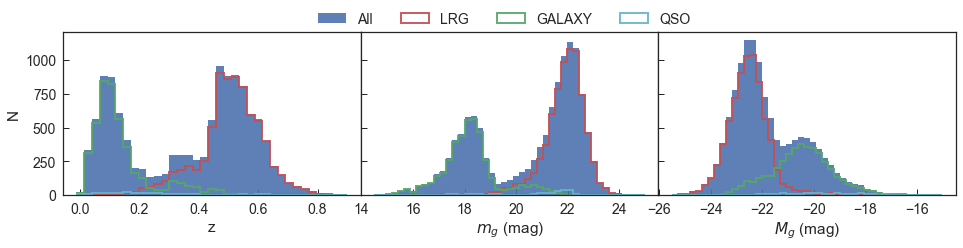

In [7]:
# plots of redshift distribution and more...
to_plot = all_1415.dropna(subset=['zsp','gmag','gMag_k']).query('zsp > 0')
fig, ax = plt.subplots(ncols=3, nrows=1,figsize = (16,3), sharey=True)
sb.distplot(to_plot.zsp, color='b', ax=ax[0], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (-.01,.9)}, bins=35)
sb.distplot(to_plot.query('spType=="LRG"').zsp, color='r', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-.01,.9)}, bins=35)
sb.distplot(to_plot.query('spType=="GALAXY"').zsp, color='g', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-.01,.9)}, bins=35)
sb.distplot(to_plot.query('spType=="QSO"').zsp, color='c', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-.01,.9)}, bins=35)
ax[0].set_xlabel('z')
ax[0].set_ylabel('N')
#ax[0].set_xlim(-.01,.9)
#ax[0,0].set_ylim(0,85)

sb.distplot(to_plot.gmag, color='b', ax=ax[1], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (14.5,25)}, bins=45)
sb.distplot(to_plot.query('spType=="LRG"').gmag, color='r', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (14.5,25)}, bins=45)
sb.distplot(to_plot.query('spType=="GALAXY"').gmag, color='g', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (14.5,25)}, bins=45)
sb.distplot(to_plot.query('spType=="QSO"').gmag, color='c', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (14.5,25)}, bins=45)
ax[1].set_xlabel('$m_g$ (mag)')
#ax[1].set_xlim(14.5,25)
#ax[0,1].set_ylim(0,85)

sb.distplot(to_plot.gMag_k, color='b', ax=ax[2], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (-25.5, -15)}, bins=45, label='All')
sb.distplot(to_plot.query('spType=="LRG"').gMag_k, color='r', ax=ax[2], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-25.5, -15)}, bins=45, label='LRG')
sb.distplot(to_plot.query('spType=="GALAXY"').gMag_k, color='g', ax=ax[2], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-25.5, -15)}, bins=45, label='GALAXY')
sb.distplot(to_plot.query('spType=="QSO"').gMag_k, color='c', ax=ax[2], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": .9,
                      "range": (-25.5, -15)}, bins=45, label='QSO')
ax[2].set_xlabel('$M_g$ (mag)')
plt.legend(loc='best', bbox_to_anchor=(0.15, +1.2),  shadow=False, ncol=4)
#ax[2].set_xlim(-25.5, -15)
fig.subplots_adjust(wspace=0)

if save_plot:
    plt.savefig('%s/figures/galaxies/GALAXIES_host_prop_k.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

In [8]:
print data_15.shape

(229, 95)


In [9]:
aux = all_1415.query('ExcessVariance_cor > -0. and ExcessVariance_cor < 0.1').ExcessVariance_cor.values
N = aux.shape[0]
N_l = N/2. - (1.96*np.sqrt(N))/2
N_h = 1+ N/2. + (1.96*np.sqrt(N))/2
print N, N_l/N*100, N_h/N*100
print np.mean(aux)
print np.std(aux)
print np.percentile(aux, 50)
print np.percentile(aux, N_l/N*100)
print np.percentile(aux, N_h/N*100)
print np.percentile(aux, 80)

#plt.hist(all_1415.query('ExcessVariance_cor > -0.1 and ExcessVariance_cor < 0.1').ExcessVariance_cor.values, bins=20)
#plt.show()

6980 48.8269990486 51.187327599
0.00103220273804
0.0016482690756
0.000778796609554
0.000763810867015
0.000793156333814
0.00132688201736


(12309, 94)


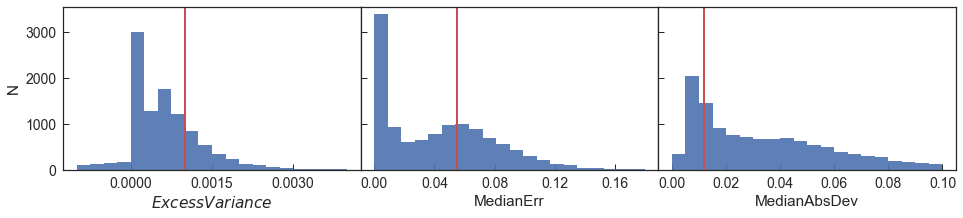

In [10]:
# plots of redshift distribution and more...
to_plot = all_1415.dropna(subset=['ExcessVariance_cor',
                                  'MedianErr',
                                  'MedianAbsDev'])#.query('Amplitude < .2')
print all_1415.shape
fig, ax = plt.subplots(ncols=3, nrows=1,figsize = (16,3), sharey=True)
sb.distplot(to_plot.ExcessVariance_cor, color='b', ax=ax[0], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (-0.001, .004),
                      "cumulative": False,
                      "normed": False}, bins=20)
ax[0].axvline(0.001, c='r', lw=2)
#ax[0].axvline(to_plot.ExcessVariance_cor.median(), c='g', lw=1.5)
#ax[0].axvline(to_plot.ExcessVariance_cor.mean(), c='g', lw=1.5)
#ax[0].axvline(to_plot.ExcessVariance_cor.median() + to_plot.ExcessVariance_cor.std(), c='g', lw=1.5)
ax[0].set_xlabel('$ExcessVariance$')
ax[0].set_ylabel('N')
#ax[0].set_ylim(0,85)
#ax[0].set_yscale('log')
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=4, prune='upper'))

sb.distplot(to_plot.MedianErr, color='b', ax=ax[1], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (0,0.18),
                      "cumulative": False,
                      "normed": False}, bins=20)
ax[1].axvline(0.055, c='r', lw=2)
#ax[1].axvline(to_plot.StdToErr.median(), c='g', lw=1.5)
#ax[1].axvline(to_plot.StdToErr.mean(), c='g', lw=1.5)
#ax[1].axvline(to_plot.StdToErr.median() + to_plot.StdToErr.std(), c='g', lw=1.5)
ax[1].set_xlabel('MedianErr')
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both'))


sb.distplot(to_plot.MedianAbsDev, color='b', ax=ax[2], kde=False,
            hist_kws={"histtype": "stepfilled",
                      "linewidth": 2.5,
                      "alpha": .9,
                      "range": (0., 0.1),
                      "cumulative": False,
                      "normed": False}, bins=20)
ax[2].axvline(0.012, c='r', lw=2)
#ax[2].axvline(to_plot.MedianAbsDev.median(), c='g', lw=1.5)
#ax[2].axvline(to_plot.MedianAbsDev.mean(), c='g', lw=1.5)
#ax[2].axvline(to_plot.MedianAbsDev.median() + to_plot.MedianAbsDev.std(), c='g', lw=1.5)
ax[2].set_xlabel('MedianAbsDev')
#ax[2].set_xlim(0, .1)
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=7, prune='both'))


fig.subplots_adjust(wspace=0)

if True:
    plt.savefig('%s/figures/galaxies/GALAXIES_feat_dist.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

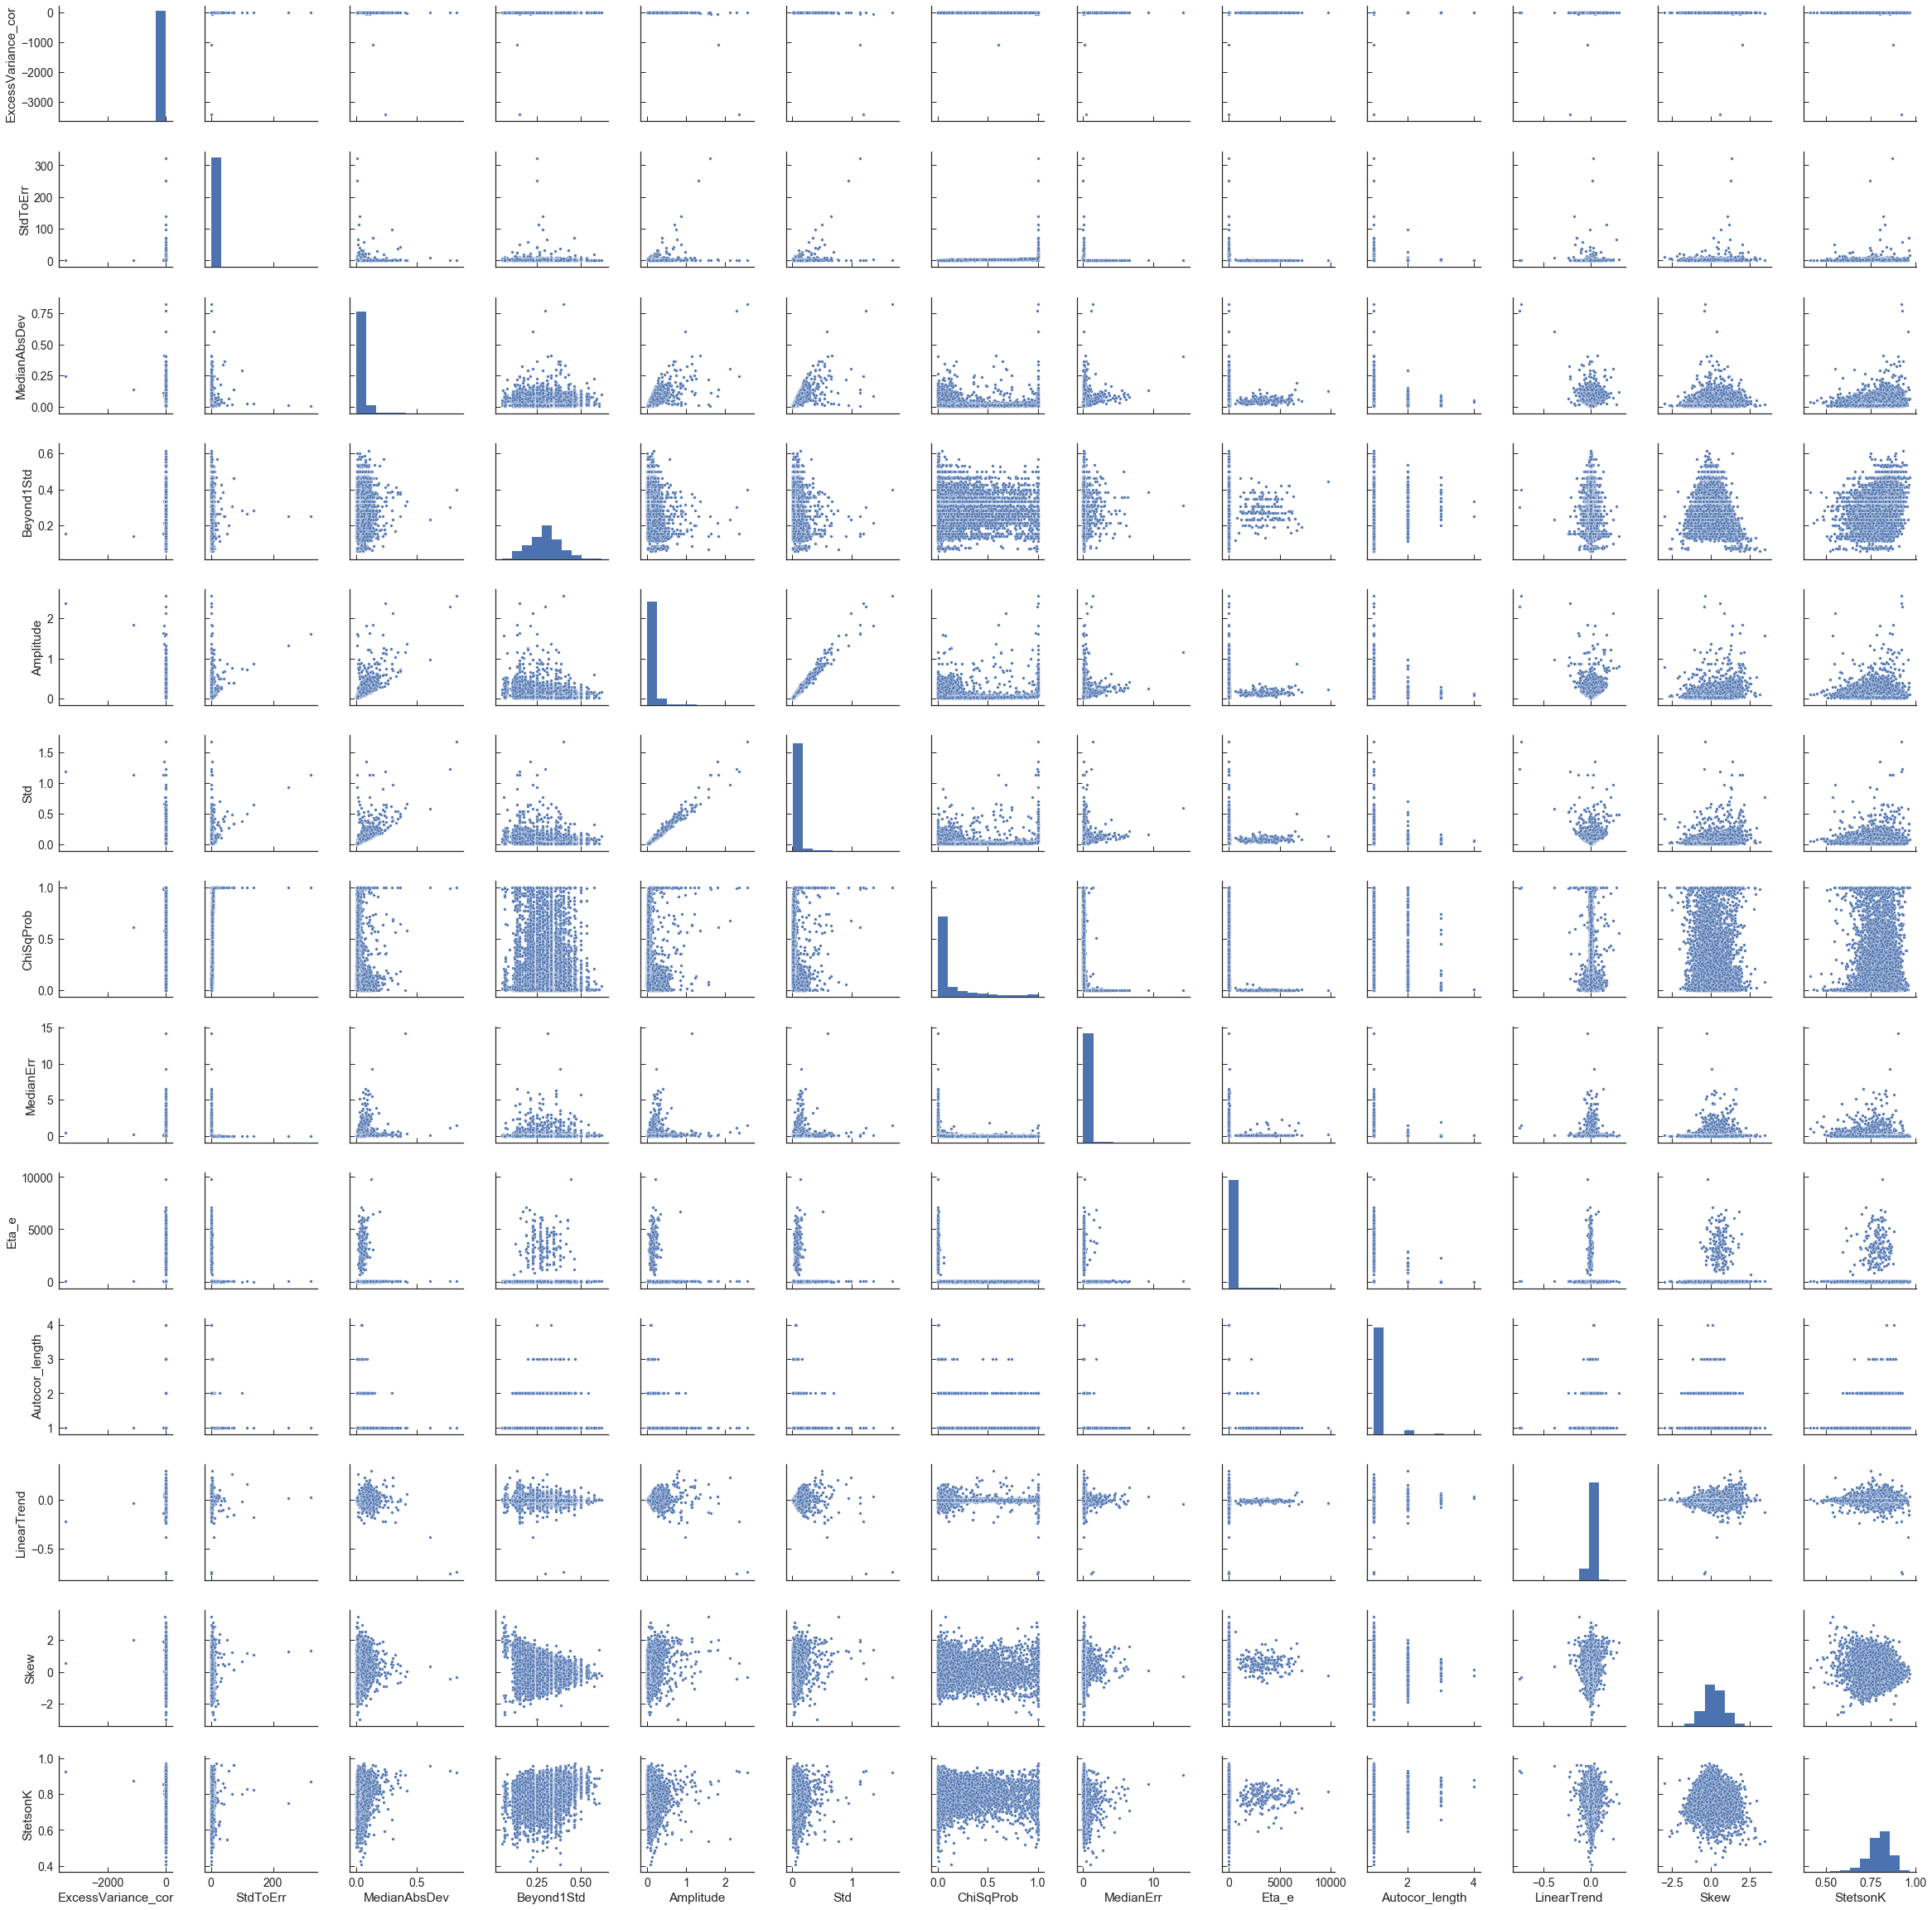

In [11]:
sb.pairplot(to_plot, vars=['ExcessVariance_cor', 'StdToErr',
                'MedianAbsDev', 'Beyond1Std',
                'Amplitude', 'Std', 'ChiSqProb',
                'MedianErr', 'Eta_e', 'Autocor_length',
                'LinearTrend', 'Skew',
                'StetsonK'], markers='.')
plt.show()

12309
0.0


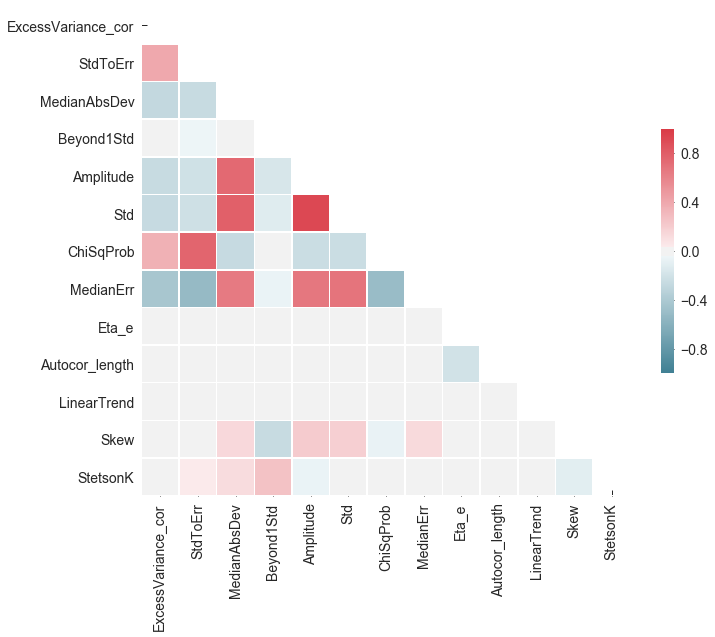

In [12]:
N = to_plot.shape[0]
print N
sigma_kendall = np.sqrt((2*(2*N+5))/(9*N*(N-1)))
print sigma_kendall
corr = to_plot[['ExcessVariance_cor', 'StdToErr',
                'MedianAbsDev', 'Beyond1Std',
                'Amplitude', 'Std', 'ChiSqProb',
                'MedianErr', 'Eta_e', 'Autocor_length',
                'LinearTrend', 'Skew',
                'StetsonK']].corr(method='kendall')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Previous works

In [13]:
liu = pd.read_csv('/Users/jorgetil/Astro/HITS/BH/Liu+18Dong+12.csv')
chil = pd.read_csv('/Users/jorgetil/Astro/HITS/BH/Chilingarian+18_imbh_table_3_x_SDSS.csv')
chil.drop('Unnamed: 0', axis=1, inplace=True)
print 'Liu          ', liu.shape
print 'Chillingarian', chil.shape

Liu           (513, 9)
Chillingarian (300, 53)


In [14]:
papers = pd.concat([liu[['z','gmag','gMag']], chil[['z','gmag','gMag']]], axis=0)
papers.head()

,z,gmag,gMag
0,0.0489,18.650000,-18.299999
1,0.1175,18.309999,-20.660000
2,0.1118,17.850000,-21.059999
3,0.2133,19.639999,-20.980000
4,0.1188,18.629999,-20.660000


In [15]:
print liu.columns.values
print chil.columns.values

['SDSS' 'z' 'gmag' 'gMag' 'gMagA' 'gMagh' 'logM' '_RA' '_DE']
['name' 'ra' 'dec' 'z' 'mbh' 'mbh_err' 'l_blr' 'l_blr_err' 'sigma_blr'
 'sigma_blr_err' 'bulge_s_mass' 'bulge_s_mass_err' 'literature' 'RAdeg'
 'DEdeg' 'errHalfMaj' 'errHalfMin' 'errPosAng' 'objID' 'mode' 'q_mode'
 'class' 'SDSS12' 'm_SDSS12' 'flags' 'ObsDate' 'Q' 'umag' 'e_umag' 'gmag'
 'e_gmag' 'rmag' 'e_rmag' 'imag' 'e_imag' 'zmag' 'e_zmag' 'zsp' 'e_zsp'
 'f_zsp' 'zph' 'e_zph' 'avg_zph' 'pmRA' 'e_pmRA' 'pmDE' 'e_pmDE' 'SpObjID'
 'spType' 'spCl' 'subClass' 'angDist' 'gMag']


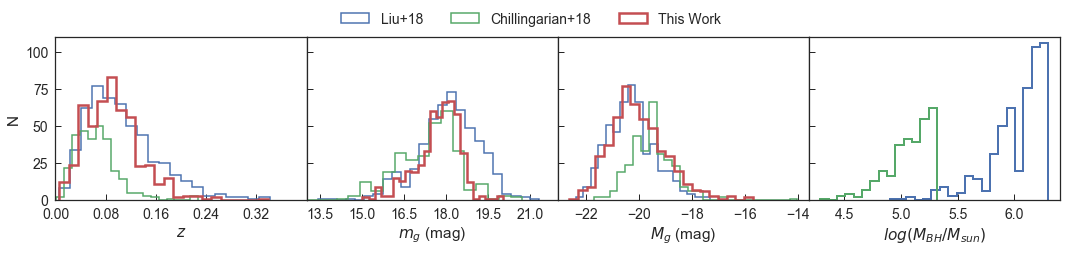

In [16]:
# plots of redshift distribution and more...
fig, ax = plt.subplots(ncols=4, nrows=1,figsize = (18,3), sharey=True)
sb.distplot(liu.z, color='b', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(chil.z, color='g', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(data.zsp, color='r', ax=ax[0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1}, bins=22)
ax[0].set_xlabel('$z$')
ax[0].set_ylabel('N')
ax[0].set_xlim(0,.4)
#ax[0,0].set_ylim(0,85)

sb.distplot(liu.gmag, color='b', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(chil.gmag, color='g', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(data.gmag, color='r', ax=ax[1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1})
ax[1].set_xlabel('$m_g$ (mag)')
ax[1].set_xlim(13,22)
#ax[0,1].set_ylim(0,85)

sb.distplot(liu.logM, color='b', ax=ax[3], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2,
                      "alpha": 1}, bins=None)
sb.distplot(np.log10(chil.mbh), color='g', ax=ax[3], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2,
                      "alpha": 1})
ax[3].set_xlabel(r'$log(M_{BH} / M_{sun})$')
#ax[3].set_ylabel('N')

sb.distplot(liu.gMag, color='b', ax=ax[2], kde=False, label='Liu+18',
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(chil.gMag, color='g', ax=ax[2], kde=False, label='Chillingarian+18',
            hist_kws={"histtype": "step",
                      "linewidth": 1.5,
                      "alpha": 1})
sb.distplot(data.gMag_k, color='r', ax=ax[2], kde=False, label='This Work',
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1})
ax[2].set_xlabel('$M_g$ (mag)')
ax[2].set_ylim(0,110)

ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='upper'))
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='upper'))
ax[2].legend(bbox_to_anchor=(0.7, 1.23), shadow=False, ncol=3)
fig.subplots_adjust(wspace=0)

if True:
    plt.savefig('%s/figures/galaxies/SIBLING_host_prop_papers_k_paper.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

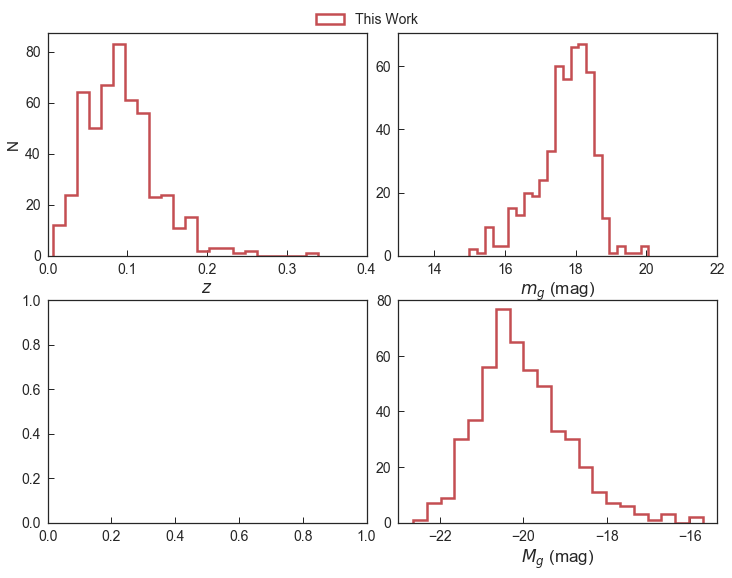

In [17]:
# plots of redshift distribution and more...
fig, ax = plt.subplots(ncols=2, nrows=2,figsize = (12,9))
#sb.distplot(liu.z, color='b', ax=ax[0,0], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
#sb.distplot(chil.z, color='g', ax=ax[0,0], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
sb.distplot(data.zsp, color='r', ax=ax[0,0], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1}, bins=22)
ax[0,0].set_xlabel('$z$', fontsize=17)
ax[0,0].set_ylabel('N')
ax[0,0].set_xlim(0,.4)
#ax[0,0].set_ylim(0,85)

#sb.distplot(liu.gmag, color='b', ax=ax[0,1], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
#sb.distplot(chil.gmag, color='g', ax=ax[0,1], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
sb.distplot(data.gmag, color='r', ax=ax[0,1], kde=False,
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1})
ax[0,1].set_xlabel('$m_g$ (mag)', fontsize=17)
ax[0,1].set_xlim(13,22)
#ax[0,1].set_ylim(0,85)

#sb.distplot(liu.logM, color='b', ax=ax[1,0], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 2,
#                      "alpha": 1}, bins=None)
#sb.distplot(np.log10(chil.mbh), color='g', ax=ax[1,0], kde=False,
#            hist_kws={"histtype": "step",
#                      "linewidth": 2,
#                      "alpha": 1})
#ax[1,0].set_xlabel(r'$log(M_{BH} / M_{sun})$')
#ax[1,0].set_ylabel('N')

#sb.distplot(liu.gMag, color='b', ax=ax[1,1], kde=False, label='Liu+18',
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
#sb.distplot(chil.gMag, color='g', ax=ax[1,1], kde=False, label='Chillingarian+18',
#            hist_kws={"histtype": "step",
#                      "linewidth": 1.5,
#                      "alpha": 1})
sb.distplot(data.gMag_k, color='r', ax=ax[1,1], kde=False, label='This Work',
            hist_kws={"histtype": "step",
                      "linewidth": 2.5,
                      "alpha": 1})
ax[1,1].set_xlabel('$M_g$ (mag)', fontsize=17)
ax[1,1].set_ylim(0,80)

#ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='upper'))
#ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='upper'))
ax[1,1].legend(bbox_to_anchor=(0.1, 2.35), shadow=False, ncol=3)
fig.subplots_adjust(wspace=0.1)

if True:
    plt.savefig('%s/figures/galaxies/SIBLING_host_prop_us.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

In [18]:
print data.spType.value_counts()
print '________________________________'
print data.spCl.value_counts()
print '________________________________'
print data.subClass.value_counts()

GALAXY              481
QA                    9
QSO                   9
BLUE_RADIO            1
SERENDIPITY_BLUE      1
Name: spType, dtype: int64
________________________________
GALAXY    501
Name: spCl, dtype: int64
________________________________
STARFORMING      255
STARBURST         34
AGN               12
BROADLINE          5
AGN BROADLINE      3
Name: subClass, dtype: int64


uncertain    252
S            216
ND            18
E             16
Name: GZ_morph, dtype: int64


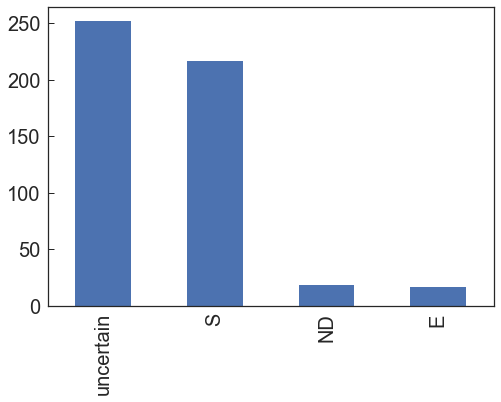

In [19]:
print data.GZ_morph.value_counts()
data.GZ_morph.value_counts().plot.bar(fontsize=20)
plt.show()

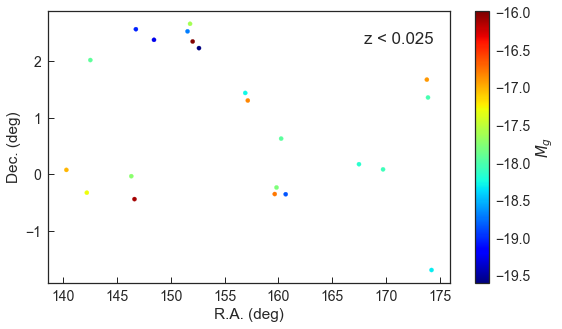

In [20]:
plt.figure(figsize=(9,5))
#plt.scatter(data.loc[xray_ids].query('zsp < 0.05 and gmag <= 17.5').raMedian,
#            data.loc[xray_ids].query('zsp < 0.05 and gmag <= 17.5').decMedian,
#            marker='+', c='k', label='X-ray counterpart',
#            s=100)
#plt.scatter(data.loc[radio_ids].query('zsp < 0.05 and gmag <= 17.5').raMedian,
#            data.loc[radio_ids].query('zsp < 0.05 and gmag <= 17.5').decMedian,
#            marker='x', c='k', label='radio counterpart',
#            s=100)

plt.scatter(data.query('zsp < 0.025').raMedian,
            data.query('zsp < 0.025').decMedian,
            marker='.', c=data.query('zsp < 0.025').gMag,
            cmap='jet', label='z < 0.02', s=70)
plt.colorbar().set_label('$M_g$', size=15)
#plt.scatter(data.query('zsp < 0.05 and gmag <= 17.').raMedian,
#            data.query('zsp < 0.05 and gmag <= 17.').decMedian,
#            marker='*', c='g', label='z < 0.05 & $m_g$ <= 17.',
#            s=50)
#plt.scatter(data.query('zsp < 0.05 and gmag <= 16.5').raMedian,
#            data.query('zsp < 0.05 and gmag <= 16.5').decMedian,
#            marker='^', c='r', label='z < 0.05 & $m_g$ <= 16.5',
#            s=50)
#plt.legend(fontsize='small', loc='best')#, bbox_to_anchor=(1.45, +.65), ncol=1)
plt.text(168, 2.3, 'z < 0.025')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.show()

In [21]:
data.loc[['Blind15A_34_N7_1583_2928',
           'Blind14A_37_N28_1841_0819',
        'Blind14A_06_N7_1537_2916']]

,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,ChiSqProb,...,GZ_morph,gMag,dist,MASS,Separation,uMag_k,gMag_k,rMag_k,iMag_k,zMag_k
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_34_N7_1583_2928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blind14A_37_N28_1841_0819,174.072318,1.295946,0.092663,0.999970,1.0,0.200000,3422.008954,0.878354,0.005829,0.997969,...,uncertain,-19.997403,311.372759,NaN,NaN,-18.567127,-19.973443,-20.727881,-21.125768,-21.362626
Blind14A_06_N7_1537_2916,154.113857,-0.120705,0.052627,0.279294,1.0,0.466667,288.092931,-0.141184,0.069710,0.785706,...,ND,-18.813292,395.419763,NaN,NaN,-17.992029,-18.891207,-19.496314,-19.919241,-20.112177


uncertain S ND E

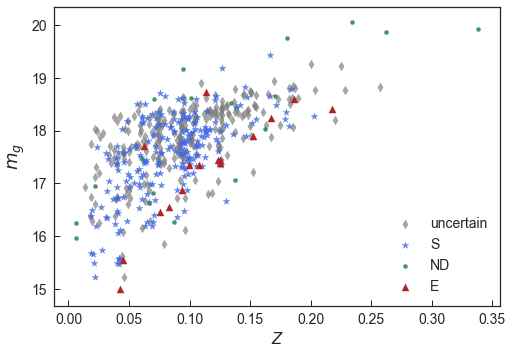

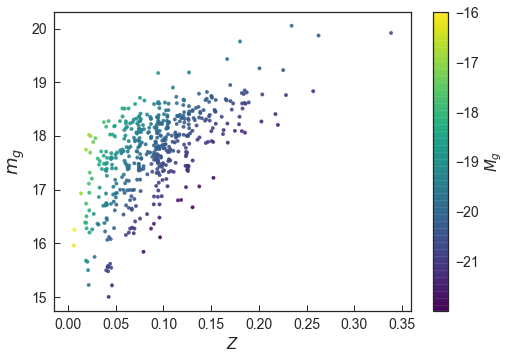

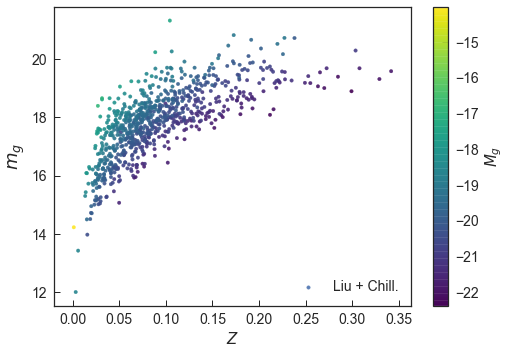

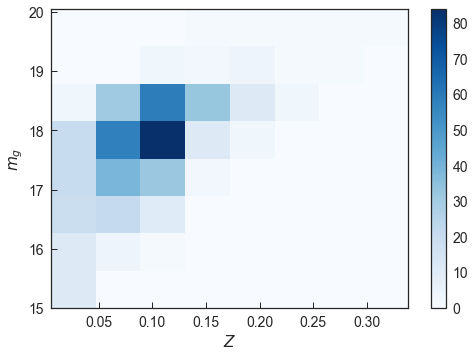

In [22]:
symbols = ['d','*','.','^']
colors = ['grey','royalblue','seagreen','firebrick']
alpha = [.7, .8, .9, 1]
s = [4, 5, 7, 5]
for k, gtype in enumerate(set(data.GZ_morph)):
    print gtype,
    toplot = data.query('GZ_morph == "%s"' % (gtype))
    plt.scatter(toplot.zsp, toplot.gmag, c=colors[k],
                marker=symbols[k], label=gtype,
                alpha=alpha[k], s=10*s[k])
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$m_{g}$', fontsize=18)
plt.legend(loc='best')
if save_plot:
    plt.savefig('%s/figures/galaxies/SIBLING_joint_morph.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

plt.scatter(data.zsp, data.gmag, c=data.gMag, cmap='viridis',
            marker='.', label=gtype, alpha=.9)
plt.colorbar().set_label('$M_g$', size=15)
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$m_{g}$', fontsize=18)
if save_plot:
    plt.savefig('%s/figures/galaxies/SIBLING_joint_absolute.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

plt.scatter(papers.z, papers.gmag, c=papers.gMag, cmap='viridis',
            marker='.', alpha=.9, label='Liu + Chill.')
plt.legend(loc='best')
plt.colorbar().set_label('$M_g$', size=15)
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$m_{g}$', fontsize=18)
if save_plot:
    plt.savefig('%s/figures/galaxies/SIBLING_joint_absolute.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

plt.hist2d(data.zsp, data.gmag, bins=8, cmap='Blues')
plt.colorbar()
plt.xlabel('$Z$')
plt.ylabel('$m_{g}$')
plt.show()

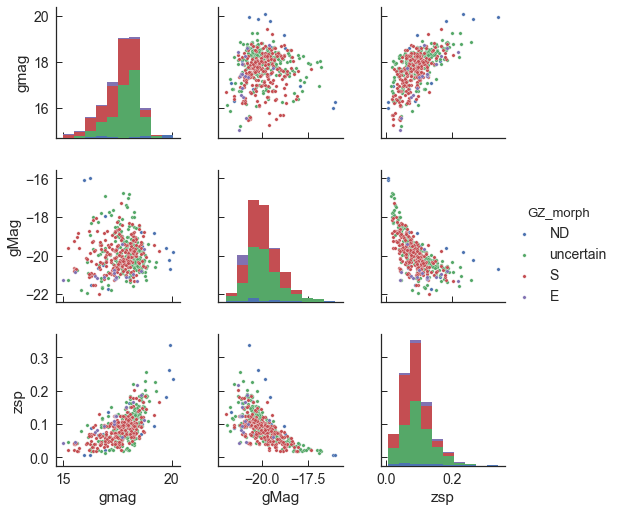

In [23]:
sb.pairplot(data, vars=['gmag','gMag','zsp'], hue='GZ_morph', markers='.')
plt.show()

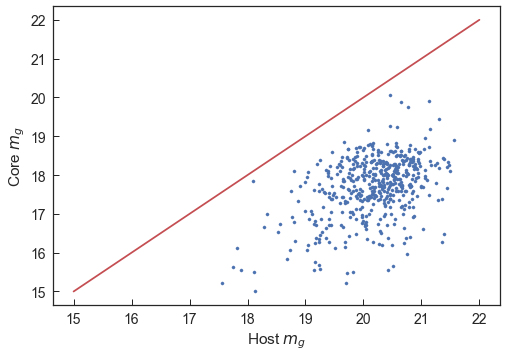

In [24]:
plt.scatter(data.Mean, data.gmag, c='b', s=10)
plt.plot([15,22], [15,22], 'r-')
plt.xlabel('Host $m_g$')
plt.ylabel('Core $m_g$')
plt.show()

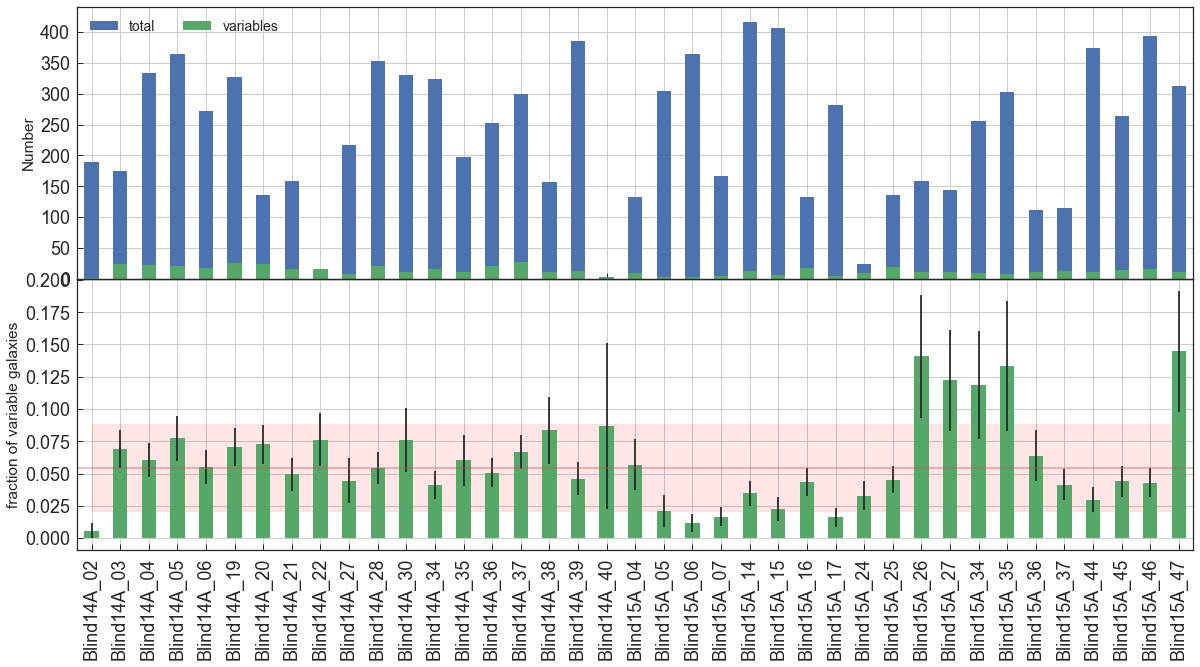

In [25]:
all_1415['Field'] = [x[:11] for x in all_1415.index.values]
data['Field'] = [x[:11] for x in data.index.values]

fields_var_count = data.Field.value_counts()
fields_all_count = all_1415.Field.value_counts()
fraction_per_field = (fields_var_count / fields_all_count).dropna()
fraction_per_field_e = (fraction_per_field * np.sqrt((np.sqrt(fields_var_count)/fields_var_count)**2 +
                                                    (np.sqrt(fields_all_count)/fields_all_count)**2)).dropna()
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10), sharex=True, squeeze=True)
fields_all_count.sort_index().plot(kind='bar', fontsize=18, color='b', ax=ax[0], label='total')
fields_var_count.sort_index().plot(kind='bar', fontsize=18, color='g', ax=ax[0], label='variables')
ax[0].set_ylabel('Number')
ax[0].legend(loc='top left', ncol=2)
ax[0].grid(True)

ax[1].axhline(np.median(fraction_per_field), color='r', alpha=.4)
fraction_per_field.sort_index().plot(kind='bar', fontsize=18, yerr=fraction_per_field_e, color='g', ax=ax[1])
ax[1].fill_between(np.arange(len(fraction_per_field)),
                  np.median(fraction_per_field) - np.std(fraction_per_field),
                  np.median(fraction_per_field) + np.std(fraction_per_field), color='red', alpha=.1)
ax[1].set_ylabel('fraction of variable galaxies')
ax[1].grid(True)
fig.subplots_adjust(hspace=0)
plt.show()

In [26]:
def plot_fraction_bins(all_data, var_data, param='gMag', nbins=12, xlabel='$M_g$'):
    
    all_data = all_data.query('zsp > 0').dropna(subset=['zsp','gMag','gMag_k','gmag'])
    var_data = var_data.query('zsp > 0').dropna(subset=['zsp','gMag','gMag_k','gmag'])
    
    var_hist, gMag_bins = np.histogram(var_data[param], bins=nbins)
    var_hist_e = np.sqrt(var_hist)
    all_hist, _ = np.histogram(all_data.query('spType=="GALAXY"')[param], bins=gMag_bins)
    all_hist_e = np.sqrt(all_hist)

    fraction = var_hist.astype(float)/all_hist.astype(float)
    fraction_e = fraction * np.sqrt((var_hist_e/var_hist)**2 + (all_hist_e/all_hist)**2)

    fig, ax = plt.subplots(1,2, figsize=(15,4))
    #plt.suptitle('All morph classes')
    ax[0].hist(all_data.query('spType=="GALAXY"')[param].dropna(), histtype='stepfilled',
             color='b', bins=gMag_bins, label='All')
    ax[0].hist(var_data[param], histtype='stepfilled', color='g', bins=gMag_bins, label='Variables')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('N')
    ax[0].legend(loc='best', fontsize='small')

    #plt.errorbar()
    ax[1].errorbar((gMag_bins[:-1] + gMag_bins[1:])/2, 
                   fraction, yerr=fraction_e, fmt='-o', c='g')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Variable Fraction')
    
    fig.subplots_adjust(wspace=.15)
    if save_plot:
        plt.savefig('%s/figures/galaxies/SIBLING_occ_frac_%s.pdf' % (mainpath, param),
            tight_layout=True, bbox_inches='tight')
    plt.show()

    for k, gtype in enumerate(set(var_data.GZ_morph)):
        var_hist, gMag_bins = np.histogram(var_data.query('GZ_morph == "%s"' % (gtype))[param],
                                           bins=nbins)
        var_hist_e = np.sqrt(var_hist)
        all_hist, _ = np.histogram(all_data.query('GZ_morph == "%s"' % 
                                                  (gtype)).query('spType=="GALAXY"')[param],
                                   bins=gMag_bins)
        all_hist_e = np.sqrt(all_hist)

        fraction = var_hist.astype(float)/all_hist.astype(float)
        fraction_e = fraction * np.sqrt((var_hist_e/var_hist)**2 +
                                        (all_hist_e/all_hist)**2)

        fig, ax = plt.subplots(1,2, figsize=(15,4))
        plt.suptitle(gtype)
        ax[0].hist(all_data.query('GZ_morph == "%s"' %
                                (gtype)).query('spType=="GALAXY"')[param].dropna(),
                 histtype='stepfilled',
                 color='b', bins=gMag_bins, label='All')
        ax[0].hist(var_data.query('GZ_morph == "%s"' % (gtype))[param],
                 histtype='stepfilled', color='g', bins=gMag_bins, label='Variables')
        ax[0].set_xlabel(xlabel)
        ax[0].set_ylabel('N')
        ax[0].legend(loc='best', fontsize='small')

        ax[1].errorbar((gMag_bins[:-1] + gMag_bins[1:])/2, 
                       fraction, yerr=fraction_e, fmt='-o', c='g')
        ax[1].set_xlabel(xlabel)
        ax[1].set_ylabel('Variable Fraction')
        plt.show()

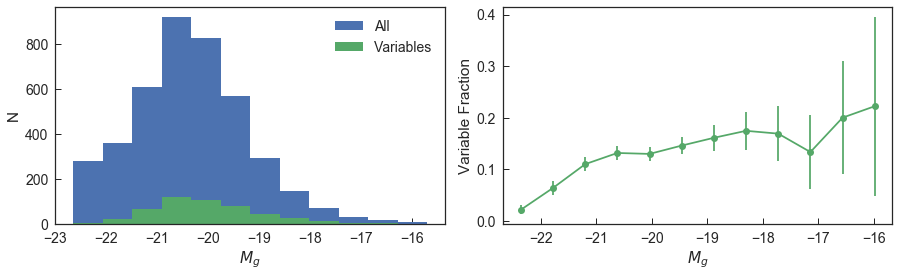

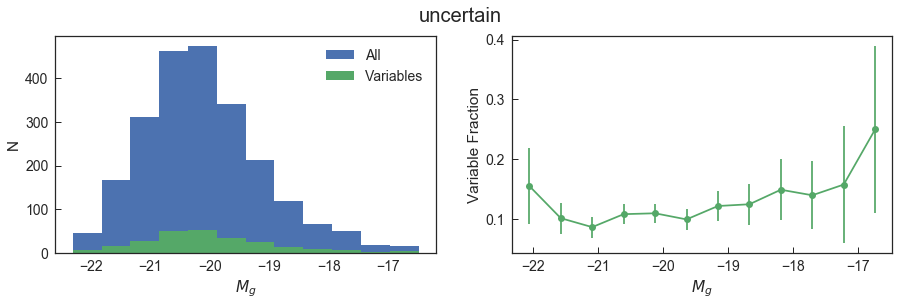

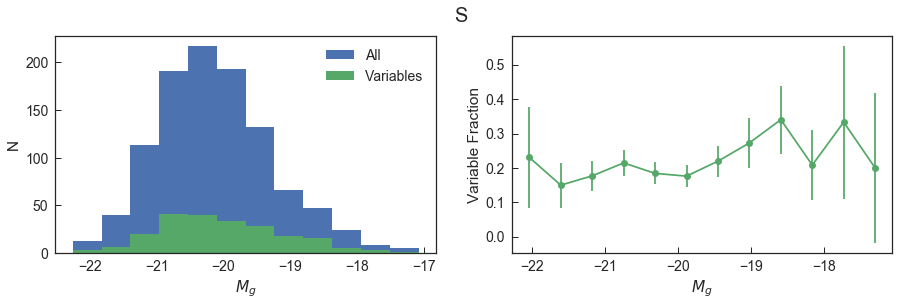

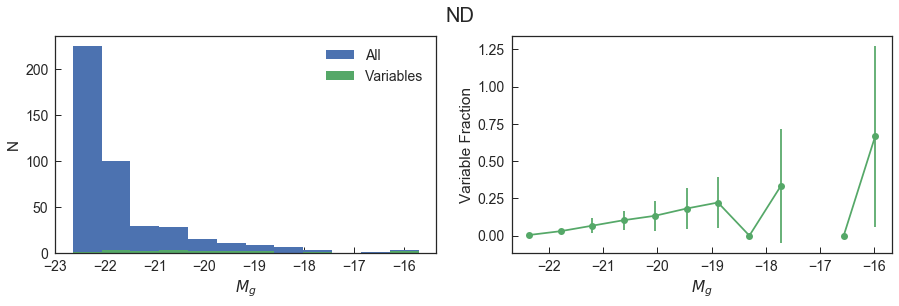

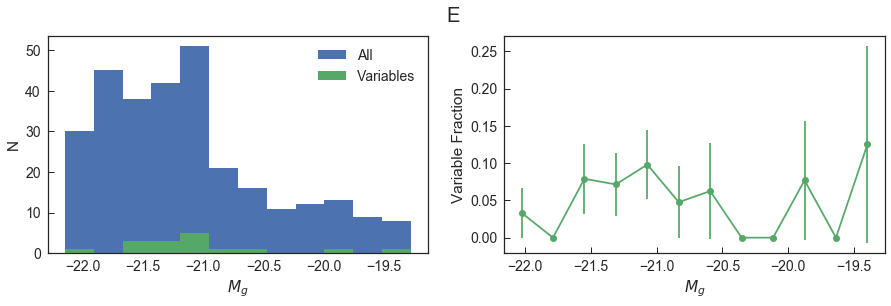

In [27]:
plot_fraction_bins(all_1415, data, param='gMag_k', nbins=12)

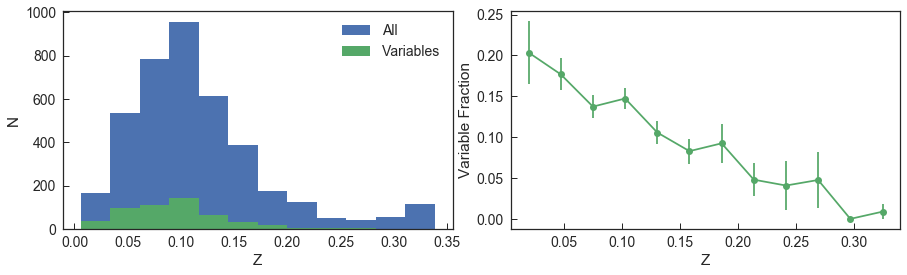

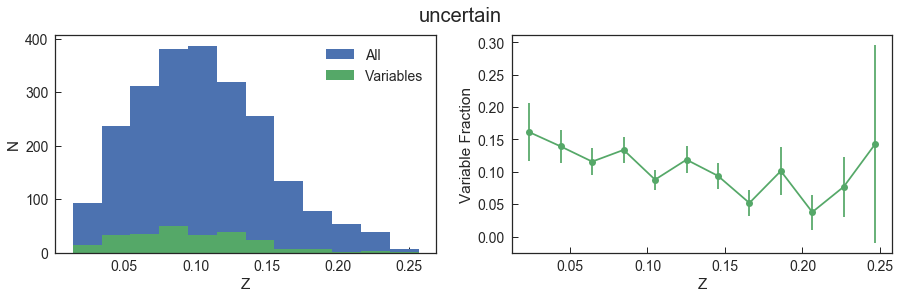

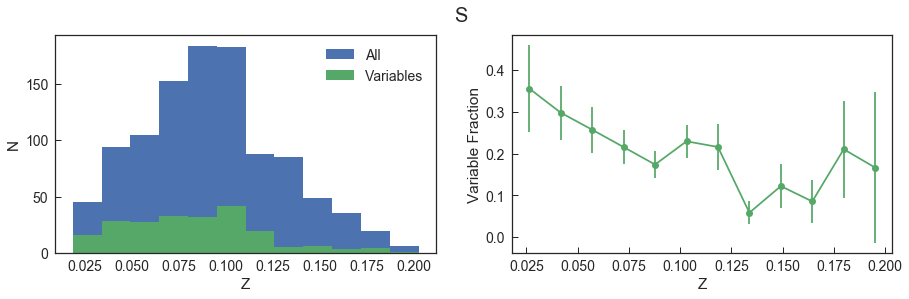

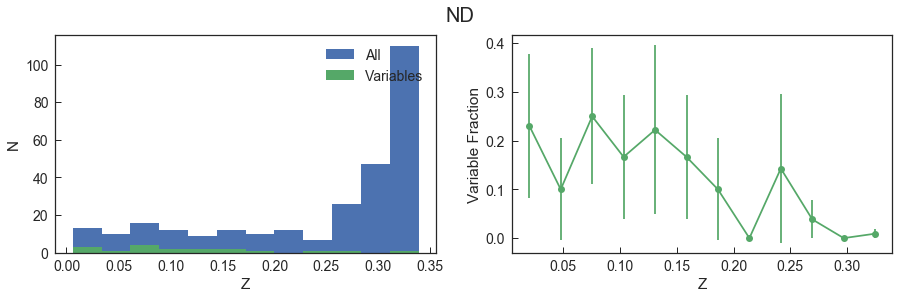

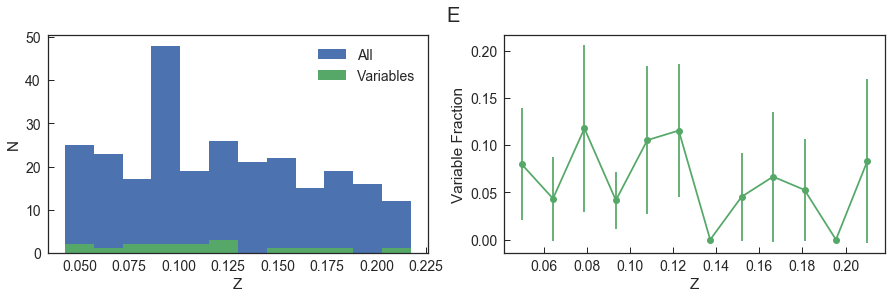

In [28]:
plot_fraction_bins(all_1415, data, param='zsp', nbins=12, xlabel='Z')

In [29]:
ids_var_both = pd.read_csv('%s/tables/galaxy/HiTS_SDSS_galaxy_VarCand_BY_ids.csv'
                               % (mainpath))
print ids_var_both.columns.values
print ids_var_both.shape

ids_both = pd.read_csv('%s/tables/galaxy/HiTS_SDSS_galaxy_BY_ids.csv'
                               % (mainpath))
print ids_both.columns.values
print ids_both.shape

['internalID_14A' 'internalID_15A']
(29, 2)
['internalID_14A' 'internalID_15A']
(1986, 2)


In [30]:
#(data_14.internalID.values - ids_var_both.internalID_14A.values) x ids_both.internalID_14
casa14 = list(data_14.index.values)
auto14 = list(ids_var_both.internalID_14A.values)
moto14 = list(ids_both.internalID_14A)
for k in auto14:
    casa14.remove(k)
print 'all minus variable repeted: ', len(casa14)
var14_not_var15 = set(casa14).intersection(moto14)
print 'variables in 14 not in 15: ', len(var14_not_var15)

casa15 = list(data_15.index.values)
auto15 = list(ids_var_both.internalID_15A.values)
moto15 = list(ids_both.internalID_15A)
for k in auto15:
    casa15.remove(k)
print 'all minus variable repeted: ', len(casa15)
var15_not_var14 = set(casa15).intersection(moto15)
print 'variables in 15 not in 14: ', len(var15_not_var14)

all minus variable repeted:  273
variables in 14 not in 15:  74
all minus variable repeted:  200
variables in 15 not in 14:  37


In [31]:
id15_var14_not15 = []
for id14 in var14_not_var15:
    id15_var14_not15.append(ids_both[ids_both.internalID_14A == id14].internalID_15A.values[0])
print len(id15_var14_not15)

id14_var15_not14 = []
for id15 in var15_not_var14:
    id14_var15_not14.append(ids_both[ids_both.internalID_15A == id15].internalID_14A.values[0])
print len(id14_var15_not14)

74
37


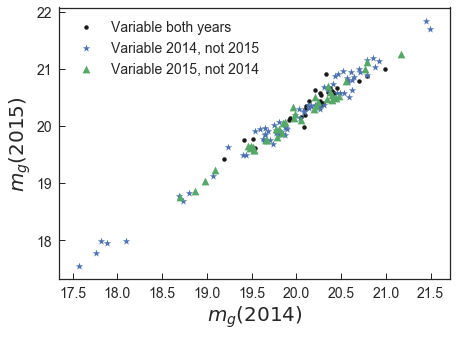

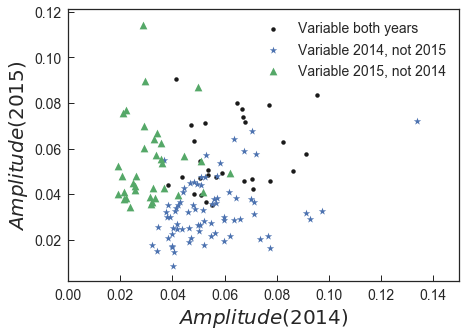

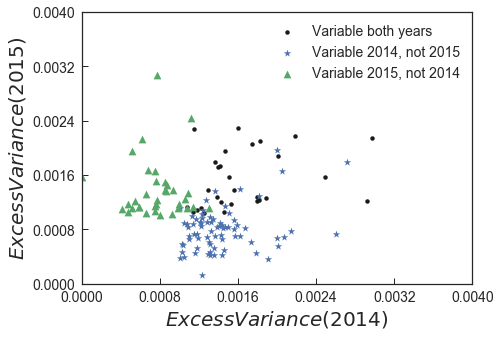

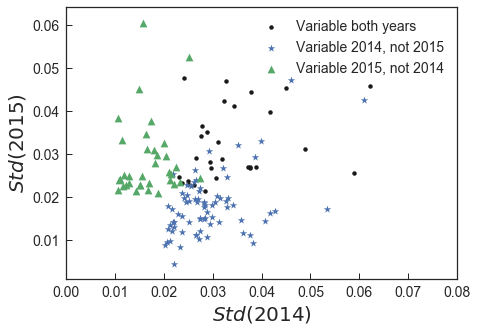

In [32]:
label = ['m_{g}', 'Amplitude', 'ExcessVariance', 'Std']
for k, feat in enumerate(['Mean', 'Amplitude', 'ExcessVariance_cor', 'Std']):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(data_14.loc[ids_var_both.internalID_14A, feat],
                data_15.loc[ids_var_both.internalID_15A, feat],
                marker='.', s=80, c='k', lw=0, label='Variable both years')
    ax.scatter(data_14.loc[var14_not_var15, feat],
                all_15.loc[id15_var14_not15, feat],
                marker='*', s=60, c='b', lw=0, label='Variable 2014, not 2015')
    ax.scatter(all_14.loc[id14_var15_not14, feat],
                data_15.loc[var15_not_var14, feat],
                marker='^', s=60, c='g', lw=0, label='Variable 2015, not 2014')
    ax.set_xlabel('$%s (2014)$' % (label[k]), fontsize=20)
    ax.set_ylabel('$%s (2015)$' % (label[k]), fontsize=20)
    if feat == 'ExcessVariance_cor':
        ax.set_xlim(0, 0.004)
        ax.set_ylim(0, 0.004)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    if feat == 'Amplitude':
        ax.set_xlim(0, 0.15)
    if feat == 'Std':
        ax.set_xlim(0, 0.08)
    plt.legend(loc='best', fontsize='small')
    if save_plot:
        plt.savefig('%s/figures/galaxies/SIBLING_14v15_%s.pdf' % (mainpath, feat),
                tight_layout=True, bbox_inches='tight')
    plt.show()

In [33]:
all_15.loc[id15_var14_not15, ['ExcessVariance_cor','MedianAbsDev',
                              'Amplitude','MedianErr','zsp','gmag']].query('ExcessVariance_cor > 0.0012')

,ExcessVariance_cor,MedianAbsDev,Amplitude,MedianErr,zsp,gmag
internalID,,,,,,
Blind15A_34_N5_1155_0381,0.001240,0.006337,0.047641,0.007361,0.07032,17.926
Blind15A_47_N17_0215_4028,0.001660,0.011764,0.057560,0.005327,0.01873,15.677
Blind15A_27_N19_0414_2591,0.001290,0.018606,0.058901,0.009768,0.04516,17.598
Blind15A_27_S11_1581_2292,0.001787,0.034911,0.072061,0.016760,0.07744,18.116
Blind15A_34_N5_0636_3455,0.001402,0.017465,0.064355,0.012034,0.09290,18.156
Blind15A_27_N27_1846_2645,0.001971,0.044884,0.067765,0.018460,0.08711,18.326
Blind15A_47_N19_1398_1887,0.001370,0.016688,0.056933,0.010174,0.08483,18.073


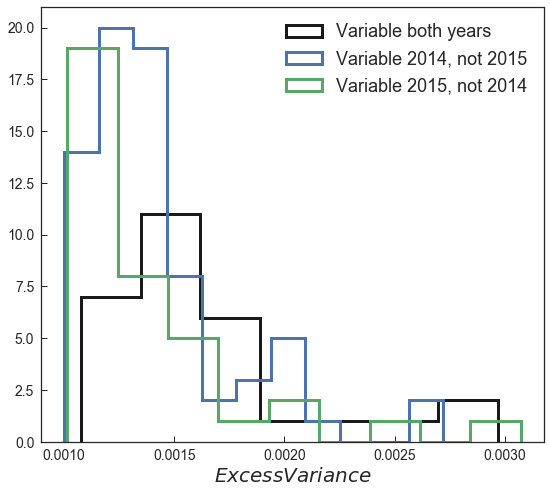

In [34]:
plt.figure(figsize=(9,8))
sb.distplot(data_14.loc[ids_var_both.internalID_14A, 'ExcessVariance_cor'],
            color='k', kde=False, label='Variable both years',
            hist_kws={"histtype": "step",
                      "linewidth": 3,
                      "alpha": 1})
sb.distplot(data_14.loc[var14_not_var15, 'ExcessVariance_cor'],
            color='b', kde=False, label='Variable 2014, not 2015',
            hist_kws={"histtype": "step",
                      "linewidth": 3,
                      "alpha": 1})
sb.distplot(data_15.loc[var15_not_var14, 'ExcessVariance_cor'],
            color='g', kde=False, label='Variable 2015, not 2014',
            hist_kws={"histtype": "step",
                      "linewidth": 3,
                      "alpha": 1})
plt.xlabel('$Excess Variance$', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.show()

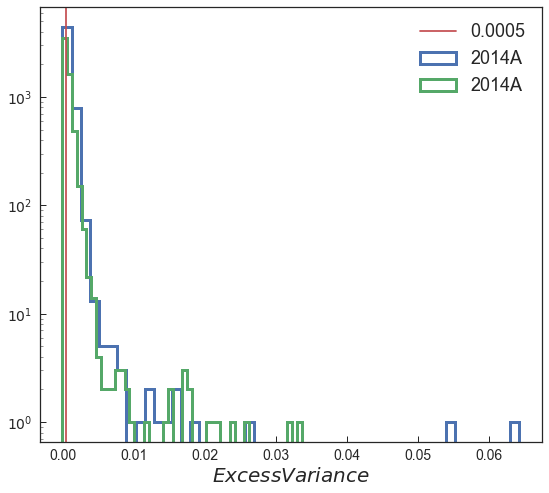

In [35]:
dits_plots14 = all_14.query('ExcessVariance_cor >= 0')
dits_plots15 = all_15.query('ExcessVariance_cor >= 0')

plt.figure(figsize=(9,8))
sb.distplot(dits_plots14.ExcessVariance_cor,
            color='b', kde=False, label='2014A',
            hist_kws={"histtype": "step",
                      "linewidth": 3,
                      "alpha": 1})
sb.distplot(dits_plots15.ExcessVariance_cor,
            color='g', kde=False, label='2014A',
            hist_kws={"histtype": "step",
                      "linewidth": 3,
                      "alpha": 1})
plt.axvline(0.0005, color='r', label='0.0005')
plt.xlabel('$Excess Variance$', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.yscale('log')
plt.show()

In [36]:
print np.median(dits_plots14.ExcessVariance_cor) + 1.5*np.std(dits_plots14.ExcessVariance_cor)

0.00286149085267


In [37]:
all_15.query('ExcessVariance_cor >= 0.0005').shape

(3150, 94)

# Candidates with Radio and/or X-ray counterpart

In [38]:
radio_ids = ['Blind15A_25_S4_1007_3019',
'Blind15A_25_N6_1150_0262',
'Blind15A_25_S18_0758_3137',
'Blind15A_34_N1_0410_1044',
'Blind15A_34_N31_1205_2283',
'Blind15A_36_S13_1461_3427',
'Blind15A_44_N8_1926_3679',
'Blind15A_45_S6_1211_1269',
'Blind15A_46_S19_0366_0520',
'Blind14A_02_S29_1788_3937',
'Blind14A_04_S3_1605_1176',
'Blind14A_06_N31_1157_2269',
'Blind14A_20_N9_1664_1398',
'Blind14A_20_S29_0332_1123',
'Blind14A_28_S11_1376_2198',
'Blind14A_28_S13_0240_1476',
'Blind14A_30_N22_0987_0899',
'Blind14A_34_N18_1549_3731',
'Blind14A_34_S4_0459_0978',
'Blind14A_35_S11_1490_3069',
'Blind14A_36_S19_1039_1411',
'Blind14A_37_S3_0238_0802']

radio_ids = np.array(list(set(radio_ids)))

In [39]:
xray_ids = ['Blind15A_24_S16_0547_2878',
'Blind15A_26_N21_1262_0810',
'Blind15A_26_S26_1436_1791',
'Blind15A_26_N5_1900_1975',
'Blind15A_37_N1_1686_2009',
'Blind15A_26_N21_1262_0810',
'Blind15A_26_S11_0080_3150',
'Blind15A_26_N5_1900_1975',
'Blind15A_24_S16_0547_2878',
'Blind15A_26_N21_1262_0810',
'Blind15A_26_S10_0523_2861',
'Blind15A_26_N11_0672_0513',
'Blind15A_26_S11_0080_3150',
'Blind15A_26_S5_1166_1285',
'Blind15A_26_N5_1900_1975',
'Blind15A_26_N6_1702_1344',
'Blind15A_26_S18_0071_3812',
'Blind14A_04_N5_1857_1973',
'Blind14A_04_S11_0314_3804',
'Blind14A_04_S15_0826_3694',
'Blind14A_04_S21_1396_0554',
'Blind14A_04_S28_0180_0452',
'Blind14A_04_S3_1605_1176',
'Blind14A_21_N18_1104_1902',
'Blind14A_04_N21_1216_0806',
'Blind14A_04_N5_1857_1973',
'Blind14A_04_S15_0826_3694',
'Blind14A_04_S21_1396_0554',
'Blind14A_04_S3_1605_1176',
'Blind14A_03_N20_0163_3328',
'Blind14A_03_N20_0842_3331',
'Blind14A_03_N21_1112_2892',
'Blind14A_03_N21_1632_1226',
'Blind14A_04_N10_0425_3373',
'Blind14A_04_N11_0628_0510',
'Blind14A_04_N20_0358_1483',
'Blind14A_04_N21_1216_0806',
'Blind14A_04_N4_1828_3131',
'Blind14A_04_N5_1857_1973',
'Blind14A_04_N6_1659_1342',
'Blind14A_04_S10_0478_2860',
'Blind14A_04_S11_0314_3804',
'Blind14A_04_S14_0316_3636',
'Blind14A_04_S15_0826_3694',
'Blind14A_04_S21_1396_0554',
'Blind14A_04_S2_0352_3430',
'Blind14A_04_S3_1605_1176',
'Blind14A_04_S5_1094_0531',
'Blind14A_06_N5_0588_3444',
'Blind14A_06_N5_1176_2635',
'Blind14A_21_N18_1501_1794']

xray_ids = np.array(list(set(xray_ids)))

In [40]:
data.loc[xray_ids].query('zsp < 0.05 and gmag <= 17.5')

,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,ChiSqProb,...,gMag,dist,MASS,Separation,uMag_k,gMag_k,rMag_k,iMag_k,zMag_k,Field
internalID,,,,,,,,,,,,,,,,,,,,,
Blind14A_21_N18_1501_1794,164.458167,1.648682,0.040628,0.226614,1.0,0.266667,649.957463,-0.182523,0.030830,0.519525,...,-19.383441,165.001603,4.566753e+09,0.426314,-18.127976,-19.224327,-19.844408,-20.143298,-20.399063,Blind14A_21
Blind14A_21_N18_1104_1902,164.466158,1.677651,0.054676,0.290489,1.0,0.200000,3621.732583,-0.515902,0.005288,0.816564,...,-20.662953,175.465050,4.617510e+10,0.380109,-18.693212,-20.438986,-21.493982,-21.994564,-22.332821,Blind14A_21
Blind14A_04_S28_0180_0452,150.469474,3.011316,0.040052,0.209373,1.0,0.400000,458.007259,-0.136046,0.038766,0.965240,...,-20.738821,186.880616,3.827348e+10,0.222090,-18.951371,-20.552825,-21.463371,-21.862643,-22.183053,Blind14A_04


# COSMOS

In [41]:
cosmos = pd.read_csv('%s/tables/galaxy/HiTS_varGalCand_in_Cosmos_CHANDRA_BSC_x_VLA_DC.csv'
                      % (mainpath))
cosmos.set_index('internalID', inplace=True)

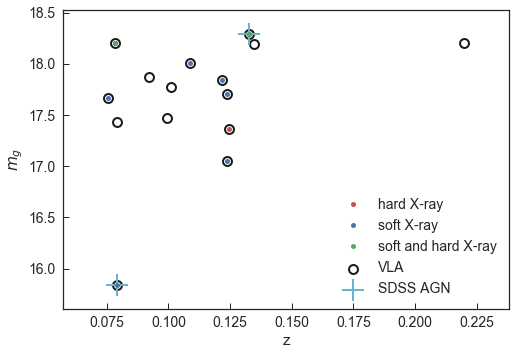

In [42]:
plt.scatter(cosmos.zsp, cosmos.gmag, c='w', label='VLA', s=80, marker='o', edgecolors='k', lw=2)
plt.plot(cosmos.query('h_flux > 0').zsp, cosmos.query('h_flux > 0').gmag, 'r.', label='hard X-ray', ms=10)
plt.plot(cosmos.query('s_flux > 0').zsp, cosmos.query('s_flux > 0').gmag, 'b.', label='soft X-ray', ms=10)
plt.plot(cosmos.query('s_flux > 0 and h_flux > 0').zsp, cosmos.query('s_flux > 0 and h_flux > 0').gmag, 'g.', label='soft and hard X-ray', ms=10)
plt.scatter(cosmos.query('subClass == "AGN" or subClass == "AGN BROADLINE"').zsp, cosmos.query('subClass == "AGN" or subClass == "AGN BROADLINE"').gmag, c='c', label='SDSS AGN', s=500, marker='+', lw=2)
plt.legend(loc='lower right')
plt.xlabel('z')
plt.ylabel('$m_g$')
plt.show()

#  BPT diagram classification

In [43]:
def SpObjID_to_PlateMjdFiber(number):
    binary = np.binary_repr(number, 64)
    pl = str(int(binary[:14], 2))
    fib = str(int(binary[14:26], 2))
    mjd = str(int(binary[26:40], 2) + 50000)

    if len(pl)==3:
        pl1='0'+pl
    else:
        pl1=pl

    if len(fib)==2:
        fib1='00'+fib
    elif len(fib)==1:
        fib1='000'+fib
    elif len(fib)==3:
        fib1='0'+fib
    else:
        fib1=fib
    return [pl1, mjd, fib1]

In [44]:
old_data_15 = pd.read_csv('%s/tables/galaxy/Blind15A_feat_SDSS_galaxy_psfmatch_variable_cand_OLD.csv.gz'
                          % (mainpath), compression='gzip')

In [45]:
old_data_15['SDSS_spec_id'] = ['spec-%s-%s-%s' % 
                                   (SpObjID_to_PlateMjdFiber(x)[0],
                                    SpObjID_to_PlateMjdFiber(x)[1],
                                    SpObjID_to_PlateMjdFiber(x)[2])
                                   for x in old_data_15.SpObjID]

In [46]:
data_spec = old_data_15.copy()
data_spec.set_index('SDSS_spec_id', inplace=True)

In [47]:
data_spec.head()

,internalID,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,...,e_pmRA,pmDE,e_pmDE,SpObjID,spType,spCl,subClass,ExcessVariance_cor,gMag,GZ_morph
SDSS_spec_id,,,,,,,,,,,,,,,,,,,,,
spec-0470-51929-0147,Blind15A_04_S1_0738_4062,5.888489e+17,09:05:45.18,-00:11:35.7,24.0,0.500,0.042,0.167,0.208,0.083,...,2.3,2.7,2.3,529213395631630336,GALAXY,GALAXY,STARFORMING,0.001282,-20.163738,uncertain
spec-0470-51929-0112,Blind15A_04_S3_0989_1516,5.877251e+17,09:07:29.52,-00:12:42.1,56.0,0.643,0.000,0.196,0.089,0.071,...,2.6,0.6,2.6,529203774904887296,GALAXY,GALAXY,NaN,0.001930,-20.762774,uncertain
spec-0471-51924-0094,Blind15A_04_S26_0463_3499,5.877251e+17,09:08:41.84,+00:29:04.9,59.0,0.983,0.000,0.017,0.000,0.000,...,2.3,6.1,2.3,530324726925518848,GALAXY,GALAXY,NaN,0.000753,-19.799480,E
spec-0470-51929-0003,Blind15A_04_N11_1521_1956,5.888489e+17,09:09:29.25,-00:34:49.4,32.0,0.094,0.000,0.406,0.031,0.094,...,2.7,7.4,2.7,529173813213030400,GALAXY,GALAXY,NaN,0.001550,-21.773738,uncertain
spec-0472-51955-0297,Blind15A_04_N17_0399_2315,5.877251e+17,09:09:35.48,-00:39:46.4,21.0,0.048,0.000,0.143,0.810,0.000,...,2.7,4.3,2.7,531506427567564800,GALAXY,GALAXY,STARFORMING,0.001385,-19.090165,S


In [48]:
SII_AGN_id = ['spec-0268-51633-0262',
'spec-0480-51989-0552',
'spec-0500-51994-0412',
'spec-0501-52235-0231',
'spec-0502-51957-0007',
'spec-0504-52316-0085',
'spec-0504-52316-0506',
'spec-0505-52317-0216',
'spec-0505-52317-0301',
'spec-0505-52317-0515',
'spec-0270-51909-0050',
'spec-0272-51941-0304',
'spec-0273-51957-0135',
'spec-0274-51913-0152',
'spec-0274-51913-0423',
'spec-0274-51913-0436',
'spec-0274-51913-0554',
'spec-0274-51913-0595',
'spec-0275-51910-0438',
'spec-0474-52000-0387',
'spec-0474-52000-0468',
'spec-0475-51965-0037',
'spec-0475-51965-0205',
'spec-0477-52026-0176',
'spec-0266-51630-0155']

NII_AGN_id = ['spec-0268-51633-0262',
'spec-4737-55630-0184',
'spec-4738-55650-0258',
'spec-4742-55660-0226',
'spec-0475-51965-0205',
'spec-0477-52026-0176',
'spec-0480-51989-0552',
'spec-0500-51994-0170',
'spec-0500-51994-0412',
'spec-0501-52235-0231',
'spec-0502-51957-0007',
'spec-0502-51957-0168',
'spec-0503-51999-0098',
'spec-0503-51999-0110',
'spec-0503-51999-0472',
'spec-0504-52316-0276',
'spec-0504-52316-0506',
'spec-0505-52317-0216',
'spec-0505-52317-0301',
'spec-0505-52317-0515',
'spec-0505-52317-0516',
'spec-0268-51633-0232',
'spec-0269-51910-0289',
'spec-0270-51909-0050',
'spec-0270-51909-0271',
'spec-0270-51909-0558',
'spec-0271-51883-0277',
'spec-0272-51941-0304',
'spec-0273-51957-0135',
'spec-0274-51913-0152',
'spec-0274-51913-0423',
'spec-0274-51913-0436',
'spec-0274-51913-0520',
'spec-0274-51913-0554',
'spec-0274-51913-0595',
'spec-0275-51910-0438',
'spec-0474-52000-0387',
'spec-0474-52000-0468',
'spec-0475-51965-0037',
'spec-0475-51965-0182',
'spec-0266-51630-0155',
'spec-0266-51630-0373',
'spec-0268-51633-0072']

SII_LINER_id = ['spec-0269-51910-0289',
'spec-0270-51909-0558',
'spec-0274-51913-0520',
'spec-0471-51924-0094',
'spec-0475-51965-0182',
'spec-0475-51965-0451',
'spec-0477-52026-0411',
'spec-0502-51957-0168',
'spec-0505-52317-0516',
'spec-4738-55650-0258',
'spec-4742-55660-0226',
'spec-0266-51630-0373',
'spec-0268-51633-0072',
'spec-0268-51633-0232']
NII_LINER_id = ['spec-0266-51630-0598',
'spec-0273-51957-0280',
'spec-0275-51910-0276',
'spec-0471-51924-0094',
'spec-0476-52314-0103',
'spec-0477-52026-0411',
'spec-0481-51908-0442',
'spec-0503-51999-0131']

In [49]:
SII_AGN = data_spec.loc[SII_AGN_id].dropna(subset=['raMedian'])
print SII_AGN.shape
NII_AGN = data_spec.loc[NII_AGN_id].dropna(subset=['raMedian'])
print NII_AGN.shape

SII_LINER = data_spec.loc[SII_LINER_id].dropna(subset=['raMedian'])
print SII_LINER.shape
NII_LINER = data_spec.loc[NII_LINER_id].dropna(subset=['raMedian'])
print NII_LINER.shape

(25, 102)
(42, 102)
(14, 102)
(8, 102)


In [62]:
ids_agns_bpt = list(set(NII_AGN.internalID.values).intersection(list(SII_AGN.internalID.values)))
print ids_agns_bpt
ids_line_bpt = list(set(NII_LINER.internalID.values).intersection(list(SII_LINER.internalID.values)))
print ids_line_bpt

['Blind15A_46_S23_0827_0413', 'Blind15A_47_S20_1232_3249', 'Blind15A_14_S14_0541_1920', 'Blind15A_14_S28_1036_1668', 'Blind15A_46_N26_0719_0817', 'Blind15A_47_S12_1702_2412', 'Blind15A_27_N3_1733_0372', 'Blind15A_44_N27_1851_0291', 'Blind15A_16_S9_0749_0285', 'Blind15A_26_N5_1900_1975', 'Blind15A_25_N16_1522_0337', 'Blind15A_34_S28_0257_2653', 'Blind15A_45_S6_1211_1269', 'Blind15A_15_N5_0921_3464', 'Blind15A_34_N31_1205_2283', 'Blind15A_45_S18_0518_0479', 'Blind15A_26_S14_0658_1175', 'Blind15A_37_N8_0163_1028', 'Blind15A_07_S19_1476_1712', 'Blind15A_47_S12_1729_1583', 'Blind15A_47_S13_0546_1411', 'Blind15A_47_N4_1009_3656', 'Blind15A_47_S9_0510_2802', 'Blind15A_24_S1_1670_0214']
['Blind15A_16_S29_1123_0382', 'Blind15A_04_S26_0463_3499']


In [64]:
data.query('subClass == "AGN" or subClass == "AGN BROADLINE"').sort_values('raMedian')

,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,ChiSqProb,...,gMag,dist,MASS,Separation,uMag_k,gMag_k,rMag_k,iMag_k,zMag_k,Field
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_14_S28_1036_1668,142.282370,0.443584,0.036080,0.957277,1.0,0.384615,722.905621,-0.193225,0.028030,0.626644,...,-20.050381,488.513135,NaN,NaN,-18.980655,-20.247101,-21.130765,-21.655807,-21.986512,Blind15A_14
Blind15A_16_N24_0245_0193,145.793346,1.185624,0.060634,0.898809,1.0,0.230769,4784.152915,0.776444,0.004066,0.992249,...,-19.398351,264.040230,NaN,NaN,-17.187847,-19.277485,-20.413464,-20.962341,-21.358502,Blind15A_16
Blind15A_27_N3_1733_0372,149.264159,0.018990,0.039419,0.345079,1.0,0.428571,5052.790459,-0.509734,0.003987,0.660867,...,-20.885920,519.019873,NaN,NaN,-19.499112,-21.121597,-21.950745,-22.340689,-22.675905,Blind15A_27
Blind14A_04_S3_1605_1176,149.743908,2.249777,0.032284,0.592650,1.0,0.357143,162.158915,-0.082937,0.122249,0.691157,...,-20.413120,551.091903,NaN,NaN,-19.370607,-20.692508,-21.511103,-21.986845,-22.275438,Blind14A_04
Blind14A_04_S15_0826_3694,149.772932,2.636134,0.041822,0.488660,1.0,0.400000,2263.373362,-0.329467,0.008255,0.921414,...,-21.764385,332.259232,NaN,NaN,-20.290385,-21.759919,-22.579744,-23.024622,-23.302694,Blind14A_04
Blind14A_04_S28_0180_0452,150.469474,3.011316,0.040052,0.209373,1.0,0.400000,458.007259,-0.136046,0.038766,0.965240,...,-20.738821,186.880616,3.827348e+10,0.222090,-18.951371,-20.552825,-21.463371,-21.862643,-22.183053,Blind14A_04
Blind14A_05_S5_0572_3718,152.819853,2.211351,0.056918,0.671680,1.0,0.214286,3405.764003,-0.557111,0.006004,0.833996,...,-19.355986,395.910639,NaN,NaN,-18.013925,-19.429512,-20.253801,-20.661382,-20.949423,Blind14A_05
Blind14A_06_N31_1157_2269,153.445187,-0.914289,0.048326,0.672064,1.0,0.214286,3526.070429,-0.519453,0.005443,0.945609,...,-17.998850,179.957525,2.123847e+10,0.279961,-15.532173,-17.791474,-18.781288,-19.363376,-19.663509,Blind14A_06
Blind15A_45_N1_1060_3729,156.044169,1.779506,0.049667,0.928569,1.0,0.133333,17835.614051,-0.935699,0.001138,0.455826,...,-20.578152,531.655580,NaN,NaN,-19.146198,-20.834626,-21.703635,-22.202287,-22.575524,Blind15A_45


In [63]:
data.query('subClass == "AGN" or subClass == "AGN BROADLINE"').loc[ids_line_bpt]

KeyError: "None of [['Blind15A_16_S29_1123_0382', 'Blind15A_04_S26_0463_3499']] are in the [index]"

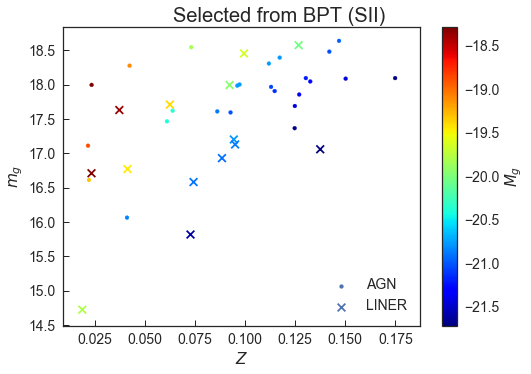

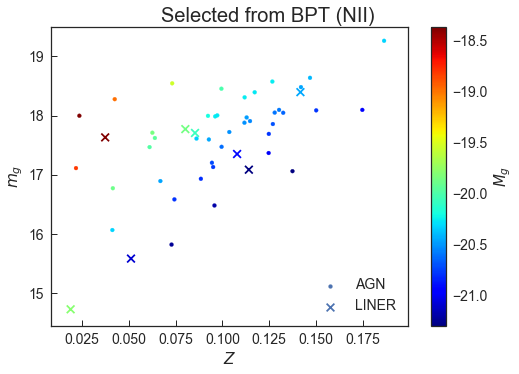

In [50]:
plt.scatter(SII_AGN.zsp, SII_AGN.gmag, c=SII_AGN.gMag, cmap='jet',
            marker='.', alpha=1., s=60, label='AGN')
plt.scatter(SII_LINER.zsp, SII_LINER.gmag, c=SII_LINER.gMag, cmap='jet',
            marker='x', alpha=1., s=60, label='LINER')
plt.legend(loc='lower right')
plt.suptitle('Selected from BPT (SII)', y=.93)
plt.colorbar().set_label('$M_g$', size=15)
plt.xlabel('$Z$')
plt.ylabel('$m_{g}$')
plt.show()

plt.scatter(NII_AGN.zsp, NII_AGN.gmag, c=NII_AGN.gMag, cmap='jet',
            marker='.', alpha=1., s=60, label='AGN')
plt.scatter(NII_LINER.zsp, NII_LINER.gmag, c=NII_LINER.gMag, cmap='jet',
            marker='x', alpha=1., s=60, label='LINER')
plt.legend(loc='lower right')
plt.suptitle('Selected from BPT (NII)', y=.93)
plt.colorbar().set_label('$M_g$', size=15)
plt.xlabel('$Z$')
plt.ylabel('$m_{g}$')
plt.show()

# Stellar masses for SDSS DR7 (Tremonti et al. 2014 )

In [51]:
def SpObjID_to_PlateMjdFiber(number):
    binary = np.binary_repr(number, 64)
    pl = int(binary[:14], 2)
    fib = int(binary[14:26], 2)
    mjd = int(binary[26:40], 2) + 50000
    '''
    if len(pl)==3:
        pl1='0'+pl
    else:
        pl1=pl

    if len(fib)==2:
        fib1='00'+fib
    elif len(fib)==1:
        fib1='000'+fib
    elif len(fib)==3:
        fib1='0'+fib
    else:
        fib1=fib
    '''
    return [pl, mjd, fib]

In [52]:
data['plate'] = [SpObjID_to_PlateMjdFiber(x)[0] for x in  data.SpObjID.values]
data['mjd'] = [SpObjID_to_PlateMjdFiber(x)[1] for x in  data.SpObjID.values]
data['fiber'] = [SpObjID_to_PlateMjdFiber(x)[2] for x in data.SpObjID.values]

In [53]:
head = ['idpl','mjd','ifib','rz','zz','d4n','hda','best','rml50','rml025',
'rml16','rml84','rml975','rmz50','rmz025','rmz975','d50','d16',
'd84','h50','h16','h84','f50','f025','f975']
tremonti = pd.read_csv('%s/SDSS/newmasses_dat_dr4.csv' % (mainpath), names=head, skiprows=1)

In [54]:
tremonti.head()

,idpl,mjd,ifib,rz,zz,d4n,hda,best,rml50,rml025,...,rmz975,d50,d16,d84,h50,h16,h84,f50,f025,f975
0,266,51630,1,-20.5983,0.0213,1.6012,2.0913,9.9558,10.2450,10.1307,...,0.4259,0.6129,0.5321,0.8176,3.0957,2.0622,4.7911,0.15,0.0,0.70
1,266,51630,2,-23.2881,0.2038,1.9116,-1.7904,11.4137,11.3536,11.2114,...,0.3527,0.0067,-0.1036,0.1641,6.5465,4.9272,8.6453,0.00,0.0,0.05
2,266,51630,4,-21.2582,0.0647,1.7026,-0.6056,10.5815,10.6109,10.4943,...,0.5387,0.5613,0.4781,0.6303,4.9577,3.3717,7.1756,0.00,0.0,0.40
3,266,51630,6,-19.2796,0.0527,1.2439,5.7818,9.0584,9.3738,9.2954,...,0.1080,0.5102,0.3254,0.7826,1.0720,0.7397,1.7952,0.00,0.0,0.60
4,266,51630,7,-22.9608,0.2139,1.7920,0.2402,11.1838,11.1321,10.9650,...,0.2622,-0.0004,-0.1516,0.1038,5.4931,3.7331,7.6764,0.00,0.0,0.35


In [55]:
stellar_mas = pd.merge(data, tremonti, how='inner',
         left_on=['plate','mjd','fiber'],
         right_on=['idpl','mjd','ifib'])

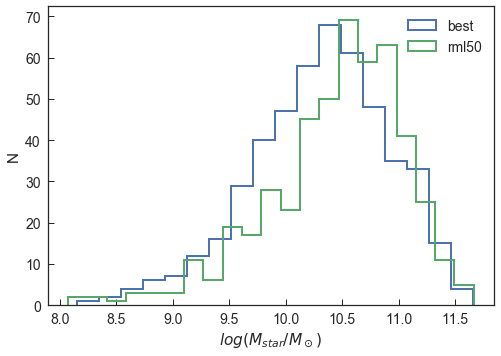

In [56]:
sb.distplot(stellar_mas.best, kde=False, color='b',
            label='best',
            hist_kws={"histtype": "step",
                      "lw": 2,
                      "alpha": 1})
sb.distplot(stellar_mas.rml50, kde=False, color='g',
            label='rml50',
            hist_kws={"histtype": "step",
                      "lw": 2,
                      "alpha": 1})
plt.legend(loc='best')
plt.xlabel('$log(M_{star}/M_\odot)$ ')
plt.ylabel('N')
plt.show()

In [57]:
stellar_mas['best_BH_mass'] = 7.45 + 1.05*stellar_mas.best - 11
stellar_mas['rml50_BH_mass'] = 7.45 + 1.05*stellar_mas.rml50 - 11

In [58]:
stellar_mas[stellar_mas.rml50_BH_mass < 6.][['best_BH_mass','rml50_BH_mass']]

,best_BH_mass,rml50_BH_mass
64,5.806130,5.754890
71,5.746385,5.889185
192,6.310130,5.902310
216,5.385815,5.209205
226,5.877950,5.955755
284,5.615030,5.078480
288,5.755520,5.540795
325,5.244380,5.166470
331,5.565470,5.668475
416,5.453855,5.600015


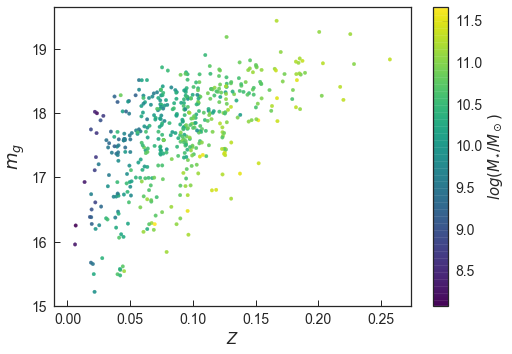

In [59]:
plt.scatter(stellar_mas.zsp, stellar_mas.gmag, c=stellar_mas.rml50, cmap='viridis',
            marker='.', label=gtype, alpha=.9)
plt.colorbar().set_label('$log(M_{\star}/M_\odot)$', size=15)
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$m_{g}$', fontsize=18)
#plt.savefig('%s/figures/galaxies/SIBLING_joint_absolute.pdf' % mainpath,
#            tight_layout=True, bbox_inches='tight')
plt.show()

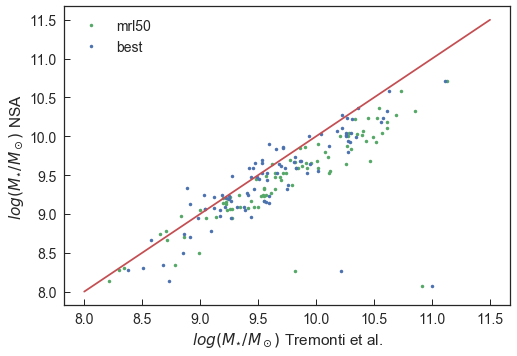

In [60]:
plt.plot(stellar_mas.rml50, np.log10(stellar_mas.MASS), '.g', label='mrl50')
plt.plot(stellar_mas.best, np.log10(stellar_mas.MASS), '.b', label='best')
plt.legend(loc=2)
plt.plot([8,11.5],[8,11.5],'-r')
plt.xlabel('$log(M_{\star}/M_\odot)$ Tremonti et al.')
plt.ylabel('$log(M_{\star}/M_\odot)$ NSA')
plt.show()

In [61]:
stellar_mas['NSA_BH_mass'] = 7.45 + 1.05*np.log10(stellar_mas.MASS) - 11

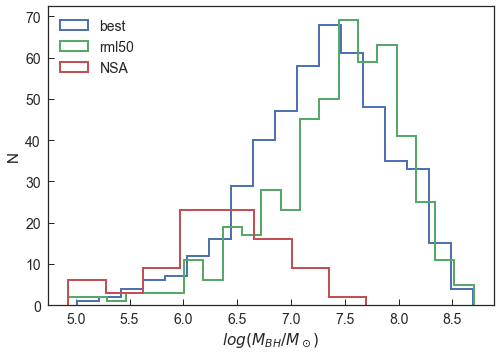

In [62]:
sb.distplot(stellar_mas.best_BH_mass, kde=False, color='b',
            label='best',
            hist_kws={"histtype": "step",
                      "lw": 2,
                      "alpha": 1})
sb.distplot(stellar_mas.rml50_BH_mass, kde=False, color='g',
            label='rml50',
            hist_kws={"histtype": "step",
                      "lw": 2,
                      "alpha": 1})
sb.distplot(stellar_mas.NSA_BH_mass.dropna(), kde=False, color='r',
            label='NSA',
            hist_kws={"histtype": "step",
                      "lw": 2,
                      "alpha": 1})
plt.legend(loc=2)
plt.xlabel('$log(M_{BH}/M_\odot)$')
plt.ylabel('N')
plt.show()

# J095858.53+021459.1

Spectral Flux Density @ 1.4GHz:  0.94192314 mJy
Spectral Flux Density @ 5GHz  :  0.778196316764 mJy
Spectral Flux Density @ 5GHz  :  7.78196316764e-27 erg / (cm2 Hz s)
____________________________________________
Luminosity distance:  624.309972964 Mpc
Luminosity distance:  1.92641928746e+27 cm
____________________________________________
Spectral Luminosity @ 5GHz:  3.62911449967e+29 erg / (Hz s)
____________________________________________
Luminosity @ 5GHz      :  1.81455724984e+39 erg / s
Luminosity @ 0.5-10 keV:  1.00925288608e+43 erg / s
____________________________________________
Luminosity (NED) @ 1.4 GHz   :  5.58e+38 erg / s
Luminosity (NED) @ 5 GHz     :  4.61007407413e+38 erg / s
Luminosity (NED) @ 0.5-10 keV:  6.12e+42 erg / s
____________________________________________
M_bh from FP      :  7.85432137805
M_bh from FP (NED):  7.25853467994
M_bh_p from FP (NED):  1.07316224035
M_bh_m from FP (NED):  15.0263763866
7.25853467994


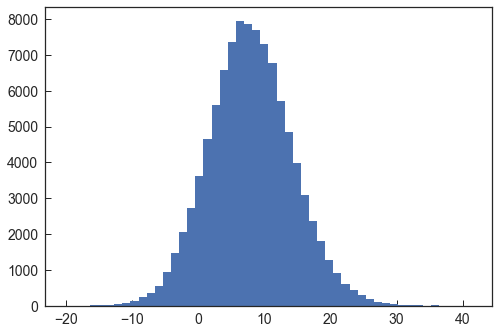

7.97363827647
7.81868307901
6.31675119032


In [63]:
mu_5 = 5e9 * u.Hz  # frequency of 5 GHz
mu_14 = 1.4e9 * u.Hz # frequency of 1.4 GHz 
S_14 = 0.94192314e-3 * u.Jy # Flux density at 1.4 GHz, in mJy
alpha = -0.15 # flat power-law spectral index-0.15 or -0.27
print 'Spectral Flux Density @ 1.4GHz: ', S_14.to(u.mJy)

log_F_5 = alpha * (np.log10(mu_5.value) - np.log10(mu_14.value)) + np.log10(S_14.value)
S_5 = 10**(log_F_5) * u.Jy
print 'Spectral Flux Density @ 5GHz  : ', S_5.to(u.mJy)
print 'Spectral Flux Density @ 5GHz  : ', S_5.to(u.erg / u.s / u.cm**2 / u.Hz)
print '____________________________________________'

z = 0.13286  # redshift

D_L = cosmo.luminosity_distance(z)  # luminosity distance
print 'Luminosity distance: ', D_L
print 'Luminosity distance: ', D_L.to(u.cm)
print '____________________________________________'
L_5 = 4 * np.pi * (D_L.to(u.cm))**2 * S_5.to(u.erg / u.s / u.cm**2 / u.Hz)
print 'Spectral Luminosity @ 5GHz: ', L_5
print '____________________________________________'
L_R = L_5.to(u.erg / u.s, equivalencies=u.spectral_density(mu_5))
print 'Luminosity @ 5GHz      : ', L_R

L_X = 10**43.004 * u.erg / u.s # X--ray luminosity non-corrected by obsorption 
                               # from Chandra-COSMOS Legacy, in ergs/s
print 'Luminosity @ 0.5-10 keV: ', L_X
print '____________________________________________'


# luminosity from NED
L_14_ned = 5.58E+31 * u.W
L_14_ned = L_14_ned.to(u.erg / u.s)
print 'Luminosity (NED) @ 1.4 GHz   : ', L_14_ned
L_5_ned = alpha * (np.log10(mu_5.value) - np.log10(mu_14.value)) + np.log10(L_14_ned.value)
L_R_ned = 10**(L_5_ned) * u.erg / u.s
print 'Luminosity (NED) @ 5 GHz     : ', L_R_ned
L_X_ned = 6.12E+35 * u.W
L_X_ned = L_X_ned.to(u.erg / u.s)
print 'Luminosity (NED) @ 0.5-10 keV: ', L_X_ned
print '____________________________________________'


## FP coef from Merloni et al. 2003
xi_M = 0.78
xi_M_p = 0.78 + 0.11
xi_M_m = 0.78 - 0.09
xi_X = 0.60
xi_X_p = 0.60 + 0.11
xi_X_m = 0.60 - 0.11
b = 7.33
b_p = 7.33 + 4.05
b_m = 7.33 - 4.07
log_M_bh = (np.log10(L_R.value) - xi_X * np.log10(L_X.value) - b) / xi_M
log_M_bh_ned = (np.log10(L_R_ned.value) - xi_X * np.log10(L_X_ned.value) - b) / xi_M
log_M_bh_ned_p = (np.log10(L_R_ned.value) - xi_X_p * np.log10(L_X_ned.value) - b) / xi_M_p
log_M_bh_ned_m = (np.log10(L_R_ned.value) - xi_X_m * np.log10(L_X_ned.value) - b) / xi_M_m
print 'M_bh from FP      : ', log_M_bh
print 'M_bh from FP (NED): ', log_M_bh_ned
print 'M_bh_p from FP (NED): ', log_M_bh_ned_p
print 'M_bh_m from FP (NED): ', log_M_bh_ned_m

print (np.log10(L_R_ned.value) - xi_X * np.log10(L_X_ned.value) - b) / xi_M


mass = []
for k in range(100000):
    xi_M = np.random.normal(0.78, 0.10)
    xi_X = np.random.normal(0.60, 0.11, )
    #b = np.random.normal(7.33, 4)
    b = 7.33
    mass.append((np.log10(L_R.value) - xi_X * np.log10(L_X.value) - b) / xi_M)
    
mass = np.array(mass)
plt.hist(mass, bins=50)
plt.show()

print np.mean(mass)
print np.median(mass)
print np.std(mass)

# Morphological classification GZ vs PL

In [67]:
from metric_tools import *
from sklearn.metrics import confusion_matrix
pl_class = pd.read_csv('%s/SDSS/GZ_PLira_morph_class.csv' % (mainpath))

In [68]:
GZ = list(pl_class.GZ_morph.values)
PL = list(pl_class.Mclass_PLira.fillna('').values)
classes = list(set().union(GZ,PL))[1:][::-1]
print classes

confusion_matrix(PL, GZ, labels=classes)

['E', 'S', 'ND', 'merger', 'irregular', 'uncertain']


array([[ 15,   1,   3,   0,   0,  49],
       [  1, 213,  10,   0,   0, 167],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   4],
       [  0,   2,   1,   0,   0,  27],
       [  0,   0,   1,   0,   0,   3]])

In [69]:
aux = pd.merge(pl_class, data, left_on='SDSS', right_on='SDSS12')
aux.head()

,SDSS,GZ_morph_x,Mclass_PLira,comments,raMedian,decMedian,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,...,Separation,uMag_k,gMag_k,rMag_k,iMag_k,zMag_k,Field,plate,mjd,fiber
0,J095939.08-011452.7,ND,E,NaN,149.912836,-1.248031,0.039226,0.403958,1.0,0.388889,...,NaN,-19.964619,-22.049260,-23.084887,-23.563396,-23.956582,Blind14A_02,269,51910,289
1,J100203.32-001249.8,uncertain,irregular,NaN,150.514068,-0.213945,0.067431,0.317077,1.0,0.333333,...,0.746909,-17.518498,-18.702570,-19.168724,-19.366864,-19.469984,Blind14A_03,268,51633,28
2,J095718.76-002814.7,S,S,NaN,149.328184,-0.470819,0.041032,0.942773,1.0,0.388889,...,NaN,-19.079172,-20.284912,-20.909404,-21.277302,-21.481720,Blind14A_03,268,51633,136
3,J095827.40-002511.8,S,S,NaN,149.614253,-0.419958,0.052083,0.938876,1.0,0.333333,...,0.681426,-17.495292,-18.518557,-19.144269,-19.453561,-19.715210,Blind14A_03,268,51633,181
4,J095935.14-003850.0,uncertain,S,late,149.896482,-0.647220,0.070439,0.955703,1.0,0.388889,...,NaN,-18.472746,-19.535641,-20.089216,-20.402264,-20.594610,Blind14A_03,268,51633,58


In [70]:
print aux.Mclass_PLira.value_counts()

S            391
E             68
irregular     30
merger         5
uncertain      4
Name: Mclass_PLira, dtype: int64


S E irregular merger uncertain

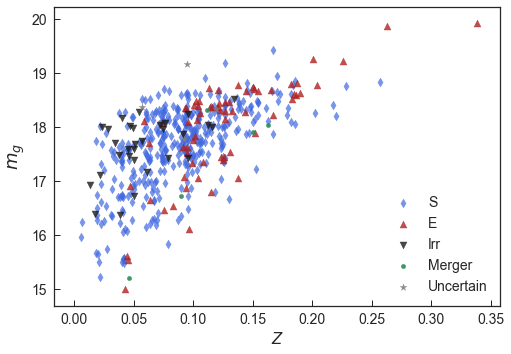

 S E irregular merger uncertain

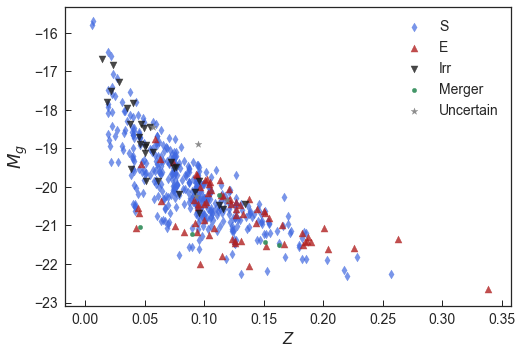

In [74]:
cl = ['S','E','irregular','merger','uncertain']
name = ['S','E','Irr','Merger','Uncertain']
symbols = ['d','^','v','.','*']
colors = ['royalblue','firebrick','k','seagreen','grey']
alpha = [.7, .8, .8, .9, .9]
s = [4, 5, 5, 8, 5]
for k, gtype in enumerate(cl):
    print gtype,
    toplot = aux.query('Mclass_PLira == "%s"' % (gtype))
    plt.scatter(toplot.zsp, toplot.gmag, c=colors[k],
                marker=symbols[k], label=name[k],
                alpha=alpha[k], s=10*s[k])
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$m_{g}$', fontsize=18)
plt.legend(loc='lower right')
if False:
    plt.savefig('%s/figures/galaxies/SIBLING_joint_morph_PL.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

for k, gtype in enumerate(cl):
    print gtype,
    toplot = aux.query('Mclass_PLira == "%s"' % (gtype))
    plt.scatter(toplot.zsp, toplot.gMag_k, c=colors[k],
                marker=symbols[k], label=name[k],
                alpha=alpha[k], s=10*s[k])
plt.xlabel('$Z$', fontsize=15)
plt.ylabel('$M_{g}$', fontsize=18)
plt.legend(loc='upper right')
if False:
    plt.savefig('%s/figures/galaxies/SIBLING_joint_morph_PL.pdf' % mainpath,
            tight_layout=True, bbox_inches='tight')
plt.show()

In [72]:
ids_R = ['J095939.08-011452.7',
'J095858.53+021459.1',
'J104450.50+030301.0',
'J110623.66+021902.9',
'J110452.51+024644.6',
'J111013.13-003424.7',
'J112447.47-015823.0',
'J112109.60+001242.7',
'J112333.92+022348.5',
'J113310.76+021410.1',
'J094258.98+020758.1',
'J095239.76+023544.3',
'J095045.67+021456.6',
'J095725.12+004351.3',
'J100827.19-000200.0',
'J102217.54+021848.5',
'J102924.18-002655.7',
'J102940.71+015555.0',
'J103919.46+021918.3',
'J104101.22+003757.5',
'J101346.81-005451.3']
ids_X = ['J100136.93+023031.9',
'J095905.51+023809.9',
'J095847.75+024531.2',
'J095858.53+021459.1',
'J100038.92+015929.6',
'J100141.98+020358.1',
'J100129.95+021705.1',
'J100152.68+030040.7',
'J105751.85+014039.8',
'J094910.54+002252.8',
'J101748.65-000150.7']
follow = ['J094628.56-002603.4',
'J100806.94+022042.4',
'J113513.64+014021.6']

In [137]:
for i in follow:
    print i
    print aux.query('SDSS == "%s"' % i).

J094628.56-002603.4
['S']
J100806.94+022042.4
['S']
J113513.64+014021.6
['irregular']


# Color-Mag diagram

In [533]:
SDSS_gal = pd.read_csv('%s/SDSS/SDSSDR12_phot_z_GALAXY.csv.gz' % (mainpath),
                       compression='gzip', skiprows=1,
                       names=['u','g','r','i','z','zsp','zsp_err','class','sourceType'],
                       dtype=float, usecols=[0,1,2,3,4,5,6])
SDSS_gal.shape

,u,g,r,i,z,zsp,zsp_err
0,21.96645,20.78178,18.99672,18.25095,17.73841,0.443788,0.000111
1,19.47666,18.16418,17.69502,17.37007,17.21460,0.091269,0.000009
2,21.66320,20.60646,18.95468,18.30738,17.95813,0.332968,0.000088
3,18.93257,17.65726,17.06016,16.71384,16.48519,0.076742,0.000014
4,19.40210,18.06931,17.48949,17.14131,16.94242,0.076630,0.000010


In [549]:
SDSS_gal = SDSS_gal.query('zsp>0 and g > 10 and g < 30 and r > 10 and r < 30')
print SDSS_gal.shape

(766208, 13)


In [548]:
lum_dist = cosmo.luminosity_distance(SDSS_gal.zsp)
for band in 'ugriz':
    SDSS_gal['%sMag_k' % band] = SDSS_gal[band] + 5 - 5*np.log10(lum_dist.to(u.pc).value) - \
                               k_corr_SDSS(SDSS_gal.g.values,
                                           SDSS_gal.r.values,
                                           SDSS_gal.zsp, band=band)

u
g
r
i
z


In [550]:
SDSS_gal['g_r'] = SDSS_gal.gMag_k - SDSS_gal.rMag_k

In [553]:
print SDSS_gal.g_r.max()
print SDSS_gal.g_r.min()

print SDSS_gal.rMag_k.max()
print SDSS_gal.rMag_k.min()

print SDSS_gal.g.max()
print SDSS_gal.g.min()
print SDSS_gal.r.max()
print SDSS_gal.r.min()

13.821759749
-12.4711576972
10.7063065935
-45.3587488075
29.89412
11.10376
29.87462
10.93589


In [486]:
from metric_tools import *
from sklearn.metrics import confusion_matrix
pl_class = pd.read_csv('%s/tables/galaxy/SIBLING_cand_PL_morph.csv' % (mainpath))
pl_class.set_index('internalID', inplace=True)

In [490]:
data = data.merge(pl_class, left_index=True, right_index=True)

(754287, 13)


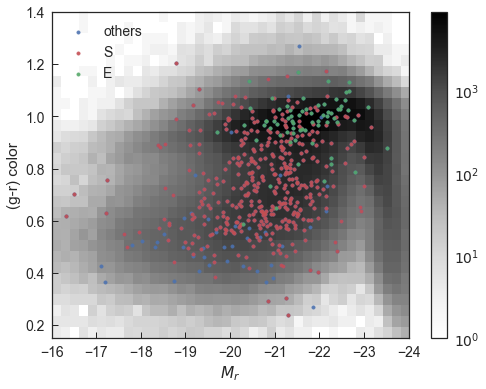

In [562]:
all_1415['g_r'] = tokde.gMag_k - tokde.rMag_k
tokde = SDSS_gal.query('g_r > 0.15 and g_r < 1.4 and '+
                       'rMag_k > -24 and rMag_k < -16')
print tokde.shape
f, ax = plt.subplots(figsize=(8,6))
#print tokde[['gMag_k','rMag_k','gmag','rmag']]
#plt.scatter(all_1415.query('spType=="LRG"').rMag_k,
#            all_1415.query('spType=="LRG"').gmag - all_1415.query('spType=="LRG"').rmag,
#            marker='.', s=5, alpha=.9, c='red')
#plt.scatter(all_1415.query('spType=="QSO"').rMag_k,
#            all_1415.query('spType=="QSO"').gmag - all_1415.query('spType=="QSO"').rmag,
#            marker='.', s=5, alpha=.9, c='k')
#ax.scatter(tokde.query('spType=="GALAXY"').rMag_k,
#           tokde.query('spType=="GALAXY"').gMag_k - tokde.query('spType=="GALAXY"').rMag_k,
#           marker='.', s=40, alpha=.5, c='b', label='all galaxies')
#cax = ax.hist2d(tokde.query('spType!="LRG"').rMag_k,
#          tokde.query('spType!="LRG"').g_r,
#          bins=[40,30], cmap='Greys', norm=mpl.colors.LogNorm())
cax = ax.hist2d(tokde.rMag_k,
                tokde.g_r,
                bins=[40,30], cmap='Greys', norm=mpl.colors.LogNorm())
f.colorbar(cax[3])
#ax = sb.kdeplot(tokde.query('spType=="GALAXY"').rMag_k,
#                tokde.query('spType=="GALAXY"').gMag_k - tokde.query('spType=="GALAXY"').rMag_k,
#                cmap='Greys', shade_lowest=False, kernel='tri', vertical=False)
ax.scatter(data.rMag_k, data.gMag_k - data.rMag_k,
            marker='.', s=50, alpha=.9, c='b', label='others')
ax.scatter(data.query('Mclass_PLira =="S"').rMag_k,
           data.query('Mclass_PLira =="S"').gMag_k - data.query('Mclass_PLira=="S"').rMag_k,
            marker='.', s=50, alpha=.9, c='r', label='S')
ax.scatter(data.query('Mclass_PLira =="E"').rMag_k,
           data.query('Mclass_PLira =="E"').gMag_k - data.query('Mclass_PLira=="E"').rMag_k,
            marker='.', s=50, alpha=.9, c='g', label='E')
#ax.set_ylim(0.15, 1.4)
#ax.set_xlim(-24, -16)
ax.set_aspect('auto')
ax.set_xlabel('$M_r$')
ax.set_ylabel('(g-r) color')
ax.legend(loc='upper left', fontsize='small')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.show()

### Distances

In [598]:
lum_dist = cosmo.luminosity_distance(data.zsp)
print lum_dist.to(u.Mpc).min()
print lum_dist.to(u.Mpc).max()
print lum_dist.to(u.Mpc).mean()
print np.median(lum_dist.to(u.Mpc))

25.9875742539 Mpc
1782.91805617 Mpc
427.849125921 Mpc
421.859916436 Mpc


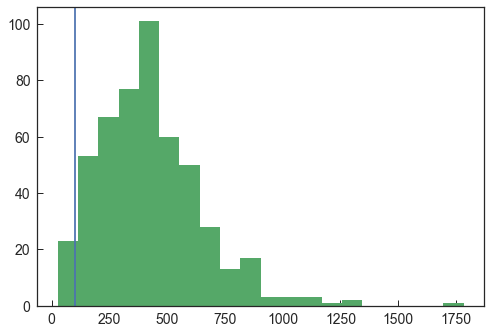

In [603]:
plt.hist(lum_dist.to(u.Mpc), bins=20)
plt.axvline(100)
plt.show()